In [28]:
# Since training take long, I like to have a voice telling me
# in which step are we in. Totally optional.
import pyttsx3
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id)
engine.say("I'm ready")
engine.runAndWait()

# Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2
import pickle
from collections import Counter, defaultdict
from itertools import product
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
from sklearn.model_selection import RepeatedKFold, train_test_split
from functools import partial, lru_cache
from copy import copy
from tqdm import tqdm, tqdm_notebook, notebook
from operator import itemgetter
from PIL import Image
from glob import glob

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble

S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Auxiliar functions definition

In [55]:
def preprocess(vector):
    i_unsigned = np.multiply(-1, vector)
    i_binary = [bin(int(n)) for n in i_unsigned]
    for index, e in enumerate(i_binary):
        if(e[0] == '-'):
            i_binary[index] = [-1, list(map(int, str(int(bin(index)[2:]))))]
        else:
            i_binary[index] = [1, list(map(int, str(int(bin(index)[2:]))))]
            
    n = int(np.log2(len(i_binary)))
    for index, element in enumerate(i_binary):
        if (len(element[1]) != n):
            while (len(i_binary[index][1]) != n):
                i_binary[index][1].insert(0, 0)
    i_binary = np.array(i_binary)
    return i_binary

def check_z(binary):
    positive = True # Controls the sign to achieve
    
    if (int(binary[0][0]) < 0):
        positive = False
    z_index = []
    for index, element in enumerate(binary):
        counts = Counter(element[1])
        if (counts[1] == 1):
            if (positive):
                if (int(binary[index][0]) == -1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
            else:
                if (int(binary[index][0]) == 1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
    return z_index

def apply_z(binary, Z):
    for z in Z:
        mask = np.array(list(map(lambda x : x[z] == 1, binary[:,1])))
        binary[mask, 0] *= -1
    return binary


def check_cpz(binary):
    CPZ = set()
    n = int(np.log2(len(binary)))
    sequence = 0
    for p in range(2, n + 1):
        for ind, e in enumerate(binary):
            counts = Counter(e[1])
            if (counts[1] == p) and (binary[0][0] != e[0]):
                ones = np.where(np.array(e[1]) == 1)[0]
                CPZ.add(tuple([sequence, tuple(ones)]))
                sequence += 1
                
                ones_set = set(ones)
                mask = np.array(list(map(partial(check_set, ones_set) , binary[:, 1])))
                
                binary[mask, 0] *= -1
                
    CPZ = [list(ele) for _, ele in enumerate(CPZ)]
    CPZ = sorted(CPZ, key = lambda l: l[0])
    CPZ = [list(e[1]) for e in CPZ]
    return CPZ

def check_set(ones_set, pos_set):
    return set.issubset(ones_set, set(np.where(np.array(pos_set) == 1)[0]))

def vectorize(number, digits):
    digits = 2**(np.ceil(np.log2(digits)))
    binary_number = bin(number)[2:]
    as_text = str(binary_number)
    vectorized_number = [int(d) for d in as_text]
    if (digits < len(vectorized_number)):
        digits = 2**(np.ceil(np.log2(len(vectorized_number))))
    if (digits > len(vectorized_number)):
        while (len(vectorized_number) != digits):
            vectorized_number.insert(0, 0)
    return np.array(vectorized_number)

def o_product(i, w):
    return (np.abs(np.dot(i, w))/len(i))**2

def sign(p):
    return np.array([(-1)**i for i in p])

def design(p):
    return [1 if i < 0 else 0 for i in w]

def reindex(N, change):
    origin = np.array([i for i in range(N)])
    destiny = np.flipud(origin)
    
    for index, element in enumerate(change):
        change[index] = np.where(destiny == element)[0][0]
    return change

def U(qc, q, Z, CPZ):
    for z in Z:
        qc.z(q[int(z)])
    
    for cpz in CPZ:
        controls = [q[int(i)] for i in cpz[:-1]]
        target = q[int(cpz[-1])]
        qc.h(cpz[-1])
        qc.mct(controls, target, None, mode='noancilla')
        qc.h(cpz[-1])
    return qc

#@lru_cache(maxsize = None)
def gates_sequence(vector):
    binary = preprocess(vector.astype('int'))
    Z_GATES = check_z(binary)
    binary = apply_z(binary, Z_GATES)
    CPZ_GATES = check_cpz(binary)
    return Z_GATES, CPZ_GATES

def perceptron(N = 1, shots = 512, z_gates_w = [], CPZ_gates_w = [], z_gates_i = [], CPZ_gates_i = [], simulation = True):
    q = QuantumRegister(N, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'qc')

    for index in range(N):
        qc.h(q[index])
        
    qc = U(qc, q, z_gates_i, CPZ_gates_i)
    qc = U(qc, q, z_gates_w, CPZ_gates_w)

    for index in range(N):
        qc.h(q[index])
    
    for index in range(N):
        qc.x(q[index])

    qc.mct(q[:], a[0], None, mode='noancilla')    
        
    qc.measure(a[0], c)
    
    transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1) # optimization_level = [0, 1, 2, 3]
    job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    results = job.result()
    
    return results #, qc # Return qc only for printing and debbuging


def fit(qubits = 1, X_train = np.array([[1]]), Y_train = np.array([[1]]), negative_class = 0, positive_class = 1, epochs = 1, shots = 64, threshold = 0.5, Ip = 0.5, In = 0.5, bias = 0, w = None):
    n = len(X_train)
    result_matrix = np.zeros((epochs, len(X_train)))
    np.random.seed(10)
    
    #w = np.random.randint(2, size = 2**qubits) # Random generation of initial weight vector. Sign it at once.

    
    #w = np.random.randint(0, 2, size = (3, 2 ** qubits)).astype('float64')
    
    #w = np.array(X_train[23])
        
    weights = []
    pos = np.array([])
    pos1 = np.array([])
    pos2 = np.array([])
    
    true_labels = np.array([x == number_negative_class for x in Y_train], dtype = 'int')

    for epoch in notebook.tqdm(range(epochs), desc = f'Epoches'):
        errors = 0
        correct = 0
        pred_labels = []
        for index, training_element in enumerate(notebook.tqdm(X_train, desc = f'Training {epoch}')):

            pattern = sign(training_element[0, :]) # Signing the training pattern.
            pattern1 = sign(training_element[1, :]) # Signing the training pattern.
            pattern2 = sign(training_element[2, :]) # Signing the training pattern.
            
            wei = sign(w[0, :]) # Signing the weight vector
            wei1 = sign(w[1, :]) # Signing the weight vector
            wei2 = sign(w[2, :]) # Signing the weight vector
            z_gates_i, CPZ_gates_i = gates_sequence(pattern) # Gates to apply to the training pattern vector
            z_gates_i1, CPZ_gates_i1 = gates_sequence(pattern1) # Gates to apply to the training pattern vector
            z_gates_i2, CPZ_gates_i2 = gates_sequence(pattern2) # Gates to apply to the training pattern vector
            z_gates_w, CPZ_gates_w = gates_sequence(wei) # Gates to apply to the weight vector
            z_gates_w1, CPZ_gates_w1 = gates_sequence(wei1) # Gates to apply to the weight vector
            z_gates_w2, CPZ_gates_w2 = gates_sequence(wei2) # Gates to apply to the weight vector
            
            
            ############################  Quantum Proccess  ############################
            
            results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            results1 = perceptron(qubits, shots, z_gates_w1, CPZ_gates_w1, z_gates_i1, CPZ_gates_i1)
            results2 = perceptron(qubits, shots, z_gates_w2, CPZ_gates_w2, z_gates_i2, CPZ_gates_i2)
            
            #########################  End of Quantum Proccess  #########################
            
            counts = results.get_counts()
            counts1 = results1.get_counts()
            counts2 = results2.get_counts()
        
            try:
                readout = counts['1'] / shots
            except KeyError:
                readout = 0
            try:
                readout1 = counts1['1'] / shots
            except KeyError:
                readout1 = 0
            try:
                readout2 = counts2['1'] / shots
            except KeyError:
                readout2 = 0
            
            readouts = np.array([readout, readout1, readout2])
            temp = np.sum(readouts < threshold)
            
            clazz = negative_class if temp >= 2 else positive_class # Classification part.
            
            pred_labels.append(clazz)
            
            result_matrix[epoch][index] = readout + bias
            
            if (Y_train[index] == clazz):
                correct += 1
                continue # Skip the execution to the next iteration
            if (clazz == negative_class): # Classified as (negative) when is (positive)
                if readouts[0] < threshold:
                    coincide = np.argwhere(training_element[0] == w[0]).flatten()
                    pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * Ip)), replace = False)))) if len(coincide) > 0 else np.array([])
                    print(f'Coincide in {len(coincide)} and change {len(pos)} bits')
                if readouts[1] < threshold:
                    coincide1 = np.argwhere(training_element[1] == w[1]).flatten()
                    pos1 = np.array(list(set(np.random.choice(coincide1, int(np.floor(len(coincide1) * Ip)), replace = False)))) if len(coincide1) > 0 else np.array([])
                    print(f'Coincide1 in {len(coincide1)} and change {len(pos1)} bits')
                if readouts[2] < threshold:
                    coincide2 = np.argwhere(training_element[2] == w[2]).flatten()
                    pos2 = np.array(list(set(np.random.choice(coincide2, int(np.floor(len(coincide2) * Ip)), replace = False)))) if len(coincide2) > 0 else np.array([])
                    print(f'Coincide2 in {len(coincide2)} and change {len(pos2)} bits')
                try:
                    w[0][pos] = (w[0][pos] + 1) % 2
                    w[1][pos1] = (w[1][pos1] + 1) % 2
                    w[2][pos2] = (w[2][pos2] + 1) % 2
                except IndexError:
                    pass
            else: # Classified as 1 (positive) when is 0 (negative)
                if readouts[0] >= threshold:
                    coincide = np.argwhere(training_element[0] == w[0]).flatten()
                    pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * In)), replace = False)))) if len(coincide) > 0 else np.array([])
                    print(f'Coincide in {len(coincide)} and change {len(pos)} bits')
                if readouts[0] >= threshold:
                    coincide1 = np.argwhere(training_element[1] == w[1]).flatten()
                    pos1 = np.array(list(set(np.random.choice(coincide1, int(np.floor(len(coincide1) * In)), replace = False)))) if len(coincide1) > 0 else np.array([])
                    print(f'Coincide1 in {len(coincide1)} and change {len(pos1)} bits')
                if readouts[0] >= threshold:
                    coincide2 = np.argwhere(training_element[2] == w[2]).flatten()
                    pos2 = np.array(list(set(np.random.choice(coincide2, int(np.floor(len(coincide2) * In)), replace = False)))) if len(coincide2) > 0 else np.array([])
                    print(f'Coincide2 in {len(coincide2)} and change {len(pos2)} bits')
                try:
                    w[0][pos] = (w[0][pos] + 1) % 2
                    w[1][pos1] = (w[1][pos1] + 1) % 2
                    w[2][pos2] = (w[2][pos2] + 1) % 2
                except IndexError:
                    pass
            errors -= -1
        print(f'Errors = {errors} for accuracy of = {1 - errors/len(X_train)}')
        weights.append(w)
        pred_labels = np.array([x == number_negative_class for x in pred_labels], dtype = 'int')
        loss = 0 if number_negative_class == number_positive_class else log_loss(true_labels, pred_labels)
    return w, result_matrix, weights, (1 - errors/len(X_train) , loss)

def predict(qubits = 1, X_test = np.array([[1]]), negative_class = 0, positive_class = 1, shots = 64, threshold = 0.5, w = 0, bias = 0):
    result_matrix = np.zeros(len(X_test))
    readout_matrix = np.zeros(len(X_test))
    np.random.seed(10)
    Y_predicted = np.zeros(len(X_test))
    wei  = sign(w[0, :]) # Signing the weight vector
    wei1 = sign(w[1, :]) # Signing the weight vector
    wei2 = sign(w[2, :]) # Signing the weight vector
    z_gates_w, CPZ_gates_w = gates_sequence(wei) # Gates to apply to the weight vector
    z_gates_w1, CPZ_gates_w1 = gates_sequence(wei1) # Gates to apply to the weight vector
    z_gates_w2, CPZ_gates_w2 = gates_sequence(wei2) # Gates to apply to the weight vector
    
    for index, training_element in enumerate(notebook.tqdm(X_test, desc = 'Predicting')):
            
        pattern = sign(training_element[0, :]) # Signing the training pattern.
        pattern1 = sign(training_element[1, :]) # Signing the training pattern.
        pattern2 = sign(training_element[2, :]) # Signing the training pattern.
            
        z_gates_i, CPZ_gates_i = gates_sequence(pattern) # Gates to apply to the training pattern vector
        z_gates_i1, CPZ_gates_i1 = gates_sequence(pattern1) # Gates to apply to the training pattern vector
        z_gates_i2, CPZ_gates_i2 = gates_sequence(pattern2) # Gates to apply to the training pattern vector
            
        ############################  Quantum Proccess  ############################
            
        results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
        results1 = perceptron(qubits, shots, z_gates_w1, CPZ_gates_w1, z_gates_i1, CPZ_gates_i1)
        results2 = perceptron(qubits, shots, z_gates_w2, CPZ_gates_w2, z_gates_i2, CPZ_gates_i2)
            
        #########################  End of Quantum Proccess  #########################
            
        counts = results.get_counts()
        counts1 = results1.get_counts()
        counts2 = results2.get_counts()
        
        try:
            readout = counts['1'] / shots
        except KeyError:
            readout = 0
        try:
            readout1 = counts1['1'] / shots
        except KeyError:
            readout1 = 0
        try:
            readout2 = counts2['1'] / shots
        except KeyError:
            readout2 = 0
        
        readouts = np.array([readout, readout1, readout2])
        temp = np.sum(readouts < threshold)

        clazz = negative_class if temp >= 2 else positive_class # Classification part.
            
        result_matrix[index] = clazz
        
        readout_matrix[index] = readout + bias

    return result_matrix, readout_matrix

def evaluate(Y_test, predicted, negative_class, positive_class):
    correct = np.argwhere(Y_test == predicted)
    accuracy = len(correct) / len(predicted)
    ones_and_zeros = [Y_test[ind][0] for ind in correct]
    counts = Counter(ones_and_zeros)
    confusion_matrix = np.zeros((2,2))
    
    Y_test_aux = np.zeros_like(Y_test)
    predicted_aux = np.zeros_like(predicted)
    
    Y_test_aux[Y_test == positive_class] = 1
    predicted_aux[predicted == positive_class] = 1
    
    for i in range(len(predicted_aux)):
        confusion_matrix[int(Y_test_aux[i])][int(predicted_aux[i])] += 1
    return accuracy, counts, confusion_matrix

def plot_confusion_matrix(cm, target_names = None, cmap = None, normalize = True, labels = True, title = 'Confusion Matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
        
    if labels:
        for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.axis('equal')
    plt.show()
    
def save_weight(filename = 'weights.txt', mode = 'a+', weight = []):
    with open(filename, mode) as file:
        file.write(f'{number_negative_class, number_positive_class}:')
        for p in w:
            file.write(f'{p},')
        file.write('\n')
        
def retrieve_weights_from_file(filename = 'weights.txt', full = False):
    with open(filename, 'r+') as file:
        lines = file.readlines()
        
        cuadratic = lambda w : int(np.abs((1 - np.sqrt(1 + 8 * w)) / 2))
        
        nc = int(np.sqrt(len(lines))) if full else cuadratic(len(lines))
        
        weights_matrix = np.empty((nc, nc), dtype = object)
    
        for line in lines:
            xy, peso = line.split(sep = ':')[0], line.split(sep = ':')[1]
            weight = np.array(list(map(int , peso.split(sep = ',')[:-1])))
            coordinates = [int(c) for c in xy if c.isdigit()]
            weights_matrix[coordinates[0]][coordinates[1]] = weight
            if not full:
                weights_matrix[coordinates[1]][coordinates[0]] = weight
    
    return weights_matrix

def process(X):
    X = X.reshape(X.shape[0], 3, -1)
    X = X < 120
    X = X.astype('float64')
    return X

# Training binary classifier
## Dataset retrieved from
### https://www.kaggle.com/sshikamaru/fruit-recognition

## Image Preprocessing and dataset selection

In [4]:
# Loading images for class 'Banana'
banana_image_list = list(map(Image.open, glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Banana/*.jpg')))
banana_filelist = glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Banana/*.jpg')
banana_images_array = [np.array(Image.open(fname)) for fname in banana_filelist]

# Loading images for class 'Onion'
onion_image_list = list(map(Image.open, glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Onion White/*.jpg')))
onion_filelist = glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Onion White/*.jpg')
onion_images_array = [np.array(Image.open(fname)) for fname in onion_filelist]

In [5]:
# Resizing all images

banana_images_array = [cv2.resize(banana_image, (16, 16), interpolation = cv2.INTER_AREA) for banana_image in banana_images_array]
onion_images_array = [cv2.resize(onion_image, (16, 16), interpolation = cv2.INTER_AREA) for onion_image in onion_images_array]

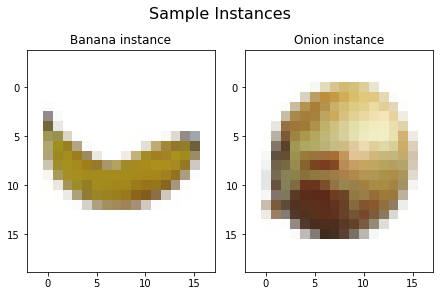

In [6]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

ax0 = axs[0]
ax0.imshow(banana_images_array[-1].reshape(16, 16, -1), cmap = 'gray')
#ax0.axis('off')
ax0.axis('equal')
ax0.set_title(f'Banana instance')

ax1 = axs[1]
ax1.imshow(onion_images_array[-1].reshape(16, 16, -1), cmap = 'gray')
#ax1.axis('off')
ax1.axis('equal')
ax1.set_title(f'Onion instance')

fig.suptitle('Sample Instances', fontsize=16)
plt.show()

In [7]:
# Constructing full dataset and labels

images = np.array(banana_images_array + onion_images_array)
number_negative_class = 0
number_positive_class = 1
targets = np.array([number_negative_class] * len(banana_images_array) + [number_positive_class] * len(onion_images_array))

In [8]:
targets_count = Counter(targets)
print(f'Total count for dataset: {targets_count}')

Total count for dataset: Counter({0: 490, 1: 438})


In [9]:
# Shuffling dataset
pre_images, pre_targets = shuffle(images, targets, random_state = 0)

In [10]:
print('Splitting dataset')

X_train, X_test, Y_train, Y_test = train_test_split(pre_images, pre_targets, test_size = 0.2, random_state = 10, shuffle = True)

print(f'Training data contains {X_train.shape[0]} instances with distribution {Counter(Y_train)}')
print(f'Test data contains {X_test.shape[0]} instances with distribution {Counter(Y_test)}')

Splitting dataset
Training data contains 742 instances with distribution Counter({0: 393, 1: 349})
Test data contains 186 instances with distribution Counter({0: 97, 1: 89})


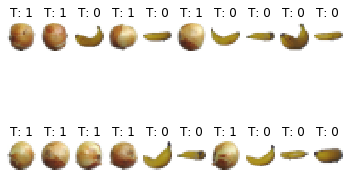

In [11]:
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[10:30]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('T: %i' % label)

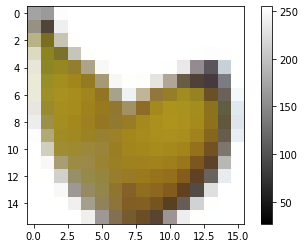

In [12]:
c = plt.imshow(np.round(X_train[100, :]), cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(c)

In [13]:
# Reshaping dataset
X_train = X_train.reshape(X_train.shape[0], 3, -1)
X_test = X_test.reshape(X_test.shape[0], 3, -1)

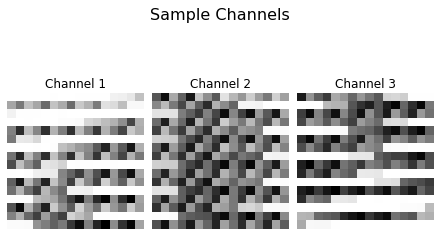

In [16]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)

sample = X_train[35]

axs[0].imshow(sample[0].reshape(16, 16), cmap = 'gray')
axs[0].axis('off')
axs[0].set_title(f'Channel 1')

axs[1].imshow(sample[1].reshape(16, 16), cmap = 'gray')
axs[1].axis('off')
axs[1].set_title(f'Channel 2')

axs[2].imshow(sample[2].reshape(16, 16), cmap = 'gray')
axs[2].axis('off')
axs[2].set_title(f'Channel 3')

fig.suptitle('Sample Channels', fontsize=16)
plt.show()

(0, 4000)

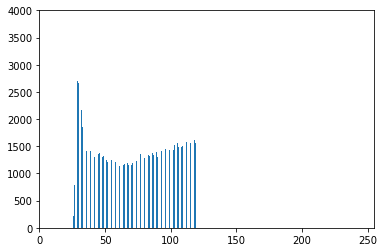

In [18]:
# Quick histogram to manually select binarization threshold
tempi = np.array([x for x in X_train.flatten() if x < 120])
plt.hist(tempi, bins = 250)
plt.xlim((0, 255))
plt.ylim((0, 4_000))

In [19]:
# Binarization via threshold
X_test = X_test < 120
X_train = X_train < 120
X_test = X_test.astype('float64')
X_train = X_train.astype('float64')

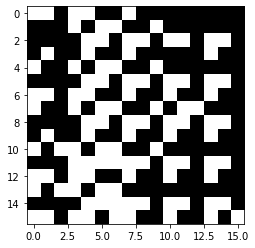

In [21]:
plt.imshow(X_train[35][1].reshape(16, 16), cmap=plt.cm.gray, interpolation='nearest')

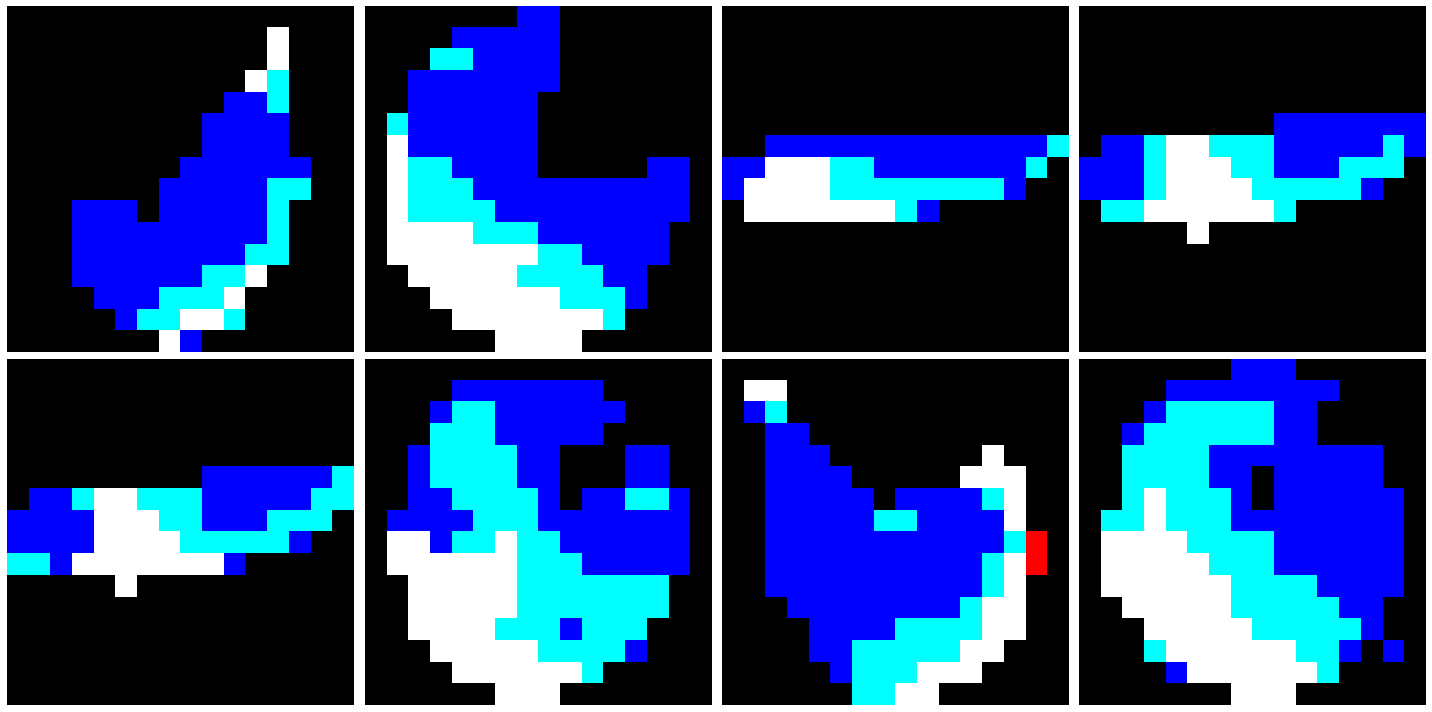

In [25]:
temp = np.array(banana_images_array + onion_images_array)
np.random.shuffle(temp)
images_and_labels = list(zip(X_train, Y_train))
plt.figure(figsize = (20,10))
for index, (image, label) in enumerate(images_and_labels[10:18]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(16, 16, -1), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.show()

## Fitting the classifier

In [72]:
Q = 8
test_threshold = 0.25
rs = 0
acc = 0
acc_threshold = 0.9
shots = 1024 * 8

print(f'Training on a 10 5-Fold cross validation. For each fold the model is trained to achieve at least {acc_threshold} in accuracy.')
# Training for accuracy instead of epochs simulates a callback

rkf = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state = 10)
metrics = defaultdict(list)

engine.say("Initiating cross validation")
engine.runAndWait()

for rep, (train_index, test_index) in enumerate(rkf.split(zo_images)):
    engine.say(f"Initiating repetition {rep + 1}")
    engine.runAndWait()
    X_train, X_test = process(zo_images[train_index]), process(zo_images[test_index])
    Y_train, Y_test = zo_targets[train_index], zo_targets[test_index]
    w = X_train[0] # Shortcut for faster training. Could and should be set to random
    acc = 0
    while acc < acc_threshold:
        w, m, weights, ae = fit(qubits = Q, X_train = X_train[:], Y_train = Y_train[:], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = test_threshold, Ip = .8, In = .1, bias = 0.0, w = w)
        classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)
        acc = accuracy_score(Y_test, classification)
        ps = precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
        rs = recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
        f1s = f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
        print(f'acc: {acc}, precision: {ps}, recall: {rs}, f1: {f1s}')
        loss = 0 if number_negative_class == number_positive_class else log_loss(Y_test, np.array([x == number_negative_class for x in classification], dtype = 'int'))
    engine.say(f"Saving metrics")
    engine.runAndWait()
    metrics['acc'].append(ae[0])
    metrics['acc_val'].append(acc)
    metrics['loss'].append(ae[1])
    metrics['lossval'].append(loss)
    metrics['precision'].append(ps)
    metrics['recall'].append(rs)
    metrics['f1'].append(f1s)
engine.say("Finished evaluation. Ready to proceed")
engine.runAndWait()

Training on a 10 5-Fold cross validation. For each fold the model is trained to achieve at least 0.9 in accuracy.


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 146 and change 116 bits
Coincide in 243 and change 24 bits
Coincide1 in 119 and change 11 bits
Coincide2 in 54 and change 5 bits
Coincide in 184 and change 147 bits
Coincide1 in 74 and change 59 bits
Coincide in 68 and change 54 bits
Coincide2 in 67 and change 53 bits
Coincide in 36 and change 3 bits
Coincide1 in 99 and change 9 bits
Coincide2 in 62 and change 6 bits
Coincide in 38 and change 3 bits
Coincide1 in 103 and change 10 bits
Coincide2 in 58 and change 5 bits
Coincide in 42 and change 4 bits
Coincide1 in 108 and change 10 bits
Coincide2 in 63 and change 6 bits
Coincide1 in 77 and change 61 bits
Coincide2 in 65 and change 52 bits
Coincide in 31 and change 3 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 75 and change 7 bits
Coincide in 34 and change 3 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 67 and change 6 

Coincide in 32 and change 3 bits
Coincide1 in 100 and change 10 bits
Coincide2 in 56 and change 5 bits
Coincide in 25 and change 2 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 60 and change 6 bits

Errors = 88 for accuracy of = 0.8814016172506739




acc: 0.8817204301075269, precision: 1.0, recall: 0.7731958762886598, f1: 0.8720930232558141


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 49 and change 4 bits
Coincide1 in 96 and change 9 bits
Coincide2 in 55 and change 5 bits
Coincide in 69 and change 55 bits
Coincide1 in 69 and change 55 bits
Coincide in 41 and change 4 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 61 and change 6 bits
Coincide in 35 and change 3 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 36 and change 3 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 47 and change 4 bits
Coincide in 31 and change 3 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 29 and change 2 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 54 and change 5 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 64 and change 51 bits
Coincide in 42 and change 4 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 73 and change 7 bits
Coincide in 39 and change 3 bits
Coincide1 in 7

Coincide1 in 68 and change 54 bits
Coincide2 in 72 and change 57 bits
Coincide in 28 and change 2 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 15 and change 1 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 77 and change 7 bits
Coincide in 18 and change 1 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 66 and change 6 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 67 and change 53 bits
Coincide in 33 and change 3 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 38 and change 3 bits
Coincide in 32 and change 3 bits
Coincide1 in 93 and change 9 bits
Coincide2 in 52 and change 5 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 66 and change 52 bits

Errors = 92 for accuracy of = 0.8760107816711591




acc: 0.9032258064516129, precision: 1.0, recall: 0.8144329896907216, f1: 0.8977272727272727


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 206 and change 20 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 101 and change 10 bits
Coincide in 169 and change 135 bits
Coincide2 in 77 and change 61 bits
Coincide in 171 and change 136 bits
Coincide2 in 65 and change 52 bits
Coincide in 60 and change 6 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 87 and change 8 bits
Coincide in 54 and change 5 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 79 and change 7 bits
Coincide in 49 and change 4 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 72 and change 7 bits
Coincide in 57 and change 5 bits
Coincide1 in 60 and cha

Coincide1 in 69 and change 55 bits
Coincide2 in 75 and change 60 bits
Coincide in 29 and change 2 bits
Coincide1 in 44 and change 4 bits
Coincide2 in 83 and change 8 bits
Coincide in 26 and change 2 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 80 and change 8 bits
Coincide1 in 80 and change 64 bits
Coincide2 in 68 and change 54 bits
Coincide in 39 and change 3 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 34 and change 3 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 40 and change 4 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 56 and change 5 bits
Coincide in 34 and change 3 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 45 and change 4 bits
Coincide in 40 and change 4 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 62 and change 6 bits
Coincide in 37 and change 3 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 61 and change 6 bits
Coincide in 37 and change 3 bits
Coincide1 in 70 and


acc: 0.9139784946236559, precision: 1.0, recall: 0.8350515463917526, f1: 0.9101123595505618


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 75 and change 60 bits
Coincide in 195 and change 19 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 54 and change 5 bits
Coincide in 170 and change 136 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 69 and change 55 bits
Coincide in 57 and change 5 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 73 and change 7 bits
Coincide in 68 and change 54 bits
Coincide1 in 64 and change 51 bits
Coincide in 33 and change 3 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 72 and


acc: 0.9354838709677419, precision: 1.0, recall: 0.8787878787878788, f1: 0.9354838709677419


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 179 and change 143 bits
Coincide1 in 179 and change 143 bits
Coincide2 in 139 and change 111 bits
Coincide in 83 and change 66 bits
Coincide1 in 86 and change 68 bits
Coincide in 38 and change 3 bits
Coincide1 in 118 and change 11 bits
Coincide2 in 211 and change 21 bits
Coincide in 35 and change 3 bits
Coincide1 in 85 and change 8 bits
Coincide2 in 212 and change 21 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 114 and change 91 bits
Coincide1 in 68 and change 54 bits
Coincide2 in 81 and change 64 bits
Coincide in 40 and change 4 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 86 and change 8 bits
Coincide in 32 and change 3 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 90 and change 9 bits
Coincide in 33 and change 3 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 74 and change 7 bits
Coincide in 27 and change 2 bits
Coincide1 in 45 and change 4 

Coincide in 20 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 78 and change 7 bits
Coincide in 26 and change 2 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 55 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 70 and change 7 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 70 and change 56 bits
Coincide in 30 and change 3 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 61 and change 6 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 64 and change 51 bits
Coincide in 27 and change 2 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 62 and change 6 bits
Coincide in 26 and change 2 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 60 and change 6 bits
Coincide in 34 and change 3 bits
Coincide1 in 85 and change 8 bits
Coincide2 in 56 and change 5 bits
Coincide in 28 and change 2 bits
Coincide1 in 64 and


acc: 0.918918918918919, precision: 0.9642857142857143, recall: 0.8709677419354839, f1: 0.9152542372881356


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide in 65 and change 52 bits
Coincide2 in 64 and change 51 bits
Coincide in 50 and change 5 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 64 and change 6 bits
Coincide in 43 and change 4 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 73 and change 7 bits
Coincide in 42 and change 4 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 64 and change 6 bits
Coincide in 37 and change 3 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 53 and change 5 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 71 and change 

Coincide in 22 and change 2 bits
Coincide1 in 75 and change 7 bits
Coincide2 in 62 and change 6 bits
Coincide in 27 and change 2 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 55 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 48 and change 4 bits
Coincide in 27 and change 2 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 54 and change 5 bits
Coincide in 17 and change 1 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 53 and change 5 bits
Coincide in 26 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 52 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 62 and change 6 bits
Coincide in 15 and change 1 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 60 and change 6 bits
Coincide in 24 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 69 and chan


acc: 0.8378378378378378, precision: 0.9868421052631579, recall: 0.7211538461538461, f1: 0.8333333333333333


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 73 and change 58 bits
Coincide1 in 90 and change 72 bits
Coincide in 47 and change 4 bits
Coincide1 in 90 and change 9 bits
Coincide2 in 45 and change 4 bits
Coincide in 44 and change 4 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 38 and change 3 bits
Coincide in 54 and change 5 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 58 and change 5 bits
Coincide in 54 and change 5 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 48 and change 4 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 65 and change 52 bits
Coincide in 53 and change 5 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 47 and change 4 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 55 and change 5 bits
Coincide in 42 and change 4 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 58 and change 5 bits
Coincide in 40 and change 4 bits
Coincide1 in 5

Coincide in 8 and change 0 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 71 and change 7 bits
Coincide in 17 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 56 and change 5 bits
Coincide in 10 and change 1 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 68 and change 6 bits
Coincide in 10 and change 1 bits
Coincide1 in 44 and change 4 bits
Coincide2 in 57 and change 5 bits
Coincide in 7 and change 0 bits
Coincide1 in 43 and change 4 bits
Coincide2 in 48 and change 4 bits
Coincide1 in 87 and change 69 bits
Coincide2 in 67 and change 53 bits
Coincide in 23 and change 2 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 48 and change 4 bits
Coincide in 8 and change 0 bits
Coincide1 in 41 and change 4 bits
Coincide2 in 52 and change 5 bits
Coincide in 17 and change 1 bits
Coincide1 in 42 and change 4 bits
Coincide2 in 48 and change 4 bits
Coincide1 in 80 and change 64 bits
Coincide2 in 69 and change 55 bits
Coincide in 10 and change 1 bits
Coincide1 in 61 and ch


acc: 0.9351351351351351, precision: 1.0, recall: 0.8846153846153846, f1: 0.9387755102040816


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 206 and change 20 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 87 and change 8 bits
Coincide in 172 and change 137 bits
Coincide2 in 70 and change 56 bits
Coincide in 61 and change 6 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 40 and change 4 bits
Coincide in 58 and change 5 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 45 and change 4 bits
Coincide in 60 and change 6 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 36 and change 3 bits
Coincide in 62 and change 6 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 117 and change 11 bits
Coincide in 63 and change 

Coincide in 21 and change 2 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 18 and change 1 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 66 and change 6 bits
Coincide in 16 and change 1 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 59 and change 5 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 64 and change 51 bits
Coincide in 10 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 119 and change 11 bits
Coincide in 9 and change 0 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 108 and change 10 bits
Coincide in 25 and change 2 bits
Coincide1 in 89 and change 8 bits
Coincide2 in 57 and change 5 bits
Coincide in 18 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 70 and change 7 bits
Coincide in 15 and change 1 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 79 and change 7 bits
Coincide in 13 and change 1 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 55 and change 5 bits

Errors = 96 for a


acc: 0.6774193548387096, precision: 1.0, recall: 0.3617021276595745, f1: 0.53125


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 77 and change 61 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 67 and change 53 bits
Coincide in 48 and change 4 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 53 and change 5 bits
Coincide in 45 and change 4 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 47 and change 4 bits
Coincide in 54 and change 5 bits
Coincide1 in 89 and change 8 bits
Coincide2 in 47 and change 4 bits
Coincide in 58 and change 5 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 59 and change 5 bits
Coincide in 53 and change 5 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 60 and change 6 bits
Coincide in 45 and change 4 bits
Coincide1 in 75 and change 7 bits
Coincide2 in 47 and change 4 bits
Coincide in 52 and change 5 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 38 and change 3 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 80

Coincide in 29 and change 2 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 26 and change 2 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 63 and change 6 bits
Coincide in 21 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 72 and change 7 bits
Coincide in 16 and change 1 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 17 and change 1 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 61 and change 6 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 68 and change 54 bits
Coincide in 32 and change 3 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 64 and change 6 bits
Coincide in 19 and change 1 bits
Coincide1 in 75 and change 7 bits
Coincide2 in 61 and change 6 bits

Errors = 92 for accuracy of = 0.8760107816711591




acc: 0.8602150537634409, precision: 1.0, recall: 0.723404255319149, f1: 0.8395061728395062


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 73 and change 58 bits
Coincide2 in 72 and change 57 bits
Coincide in 28 and change 2 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 56 and change 5 bits
Coincide in 27 and change 2 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 43 and change 4 bits
Coincide in 22 and change 2 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 38 and change 3 bits
Coincide in 24 and change 2 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 49 and change 4 bits
Coincide in 16 and change 1 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 14 and change 1 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 48 and change 4 bits
Coincide in 24 

Coincide in 25 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 55 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 55 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 57 and change 5 bits
Coincide in 17 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 60 and change 6 bits
Coincide in 14 and change 1 bits
Coincide1 in 45 and change 4 bits
Coincide2 in 48 and change 4 bits
Coincide in 11 and change 1 bits
Coincide1 in 41 and change 4 bits
Coincide2 in 44 and change 4 bits
Coincide in 11 and change 1 bits
Coincide1 in 36 and change 3 bits
Coincide2 in 44 and change 4 bits
Coincide1 in 74 and change 59 bits
Coincide2 in 66 and change 52 bits
Coincide in 27 and change 2 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 57 and change 5 bits

Errors = 94 for accuracy of = 0.8733153638814016




acc: 0.9193548387096774, precision: 1.0, recall: 0.8404255319148937, f1: 0.9132947976878613


Coincide in 204 and change 20 bits
Coincide1 in 166 and change 16 bits
Coincide2 in 205 and change 20 bits
Coincide in 192 and change 153 bits
Coincide1 in 178 and change 142 bits
Coincide in 54 and change 5 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 192 and change 19 bits
Coincide in 75 and change 60 bits
Coincide1 in 77 and change 61 bits
Coincide in 49 and change 4 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 216 and change 21 bits
Coincide in 48 and change 4 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 196 and change 19 bits
Coincide1 in 67 and change 53 bits
Coincide2 in 190 and change 152 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 82 and change 65 bits
Coincide in 57 and change 5 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 63 and change 6 bits
Coincide in 53 and change 5 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 56 and change 5 bits
Coincide in 51 and change 5 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 72 and change 7 bi

Coincide1 in 75 and change 60 bits
Coincide2 in 70 and change 56 bits
Coincide in 22 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 46 and change 4 bits
Coincide in 13 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 27 and change 2 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 58 and change 5 bits
Coincide1 in 68 and change 54 bits
Coincide2 in 66 and change 52 bits
Coincide in 13 and change 1 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 12 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 55 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 47 and change 4 bits
Coincide in 15 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 66 and change 6 bits
Coincide in 11 and change 1 bits
Coincide1 in 61 and


acc: 0.9139784946236559, precision: 1.0, recall: 0.8415841584158416, f1: 0.913978494623656


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide in 65 and change 52 bits
Coincide2 in 64 and change 51 bits
Coincide in 47 and change 4 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 89 and change 8 bits
Coincide in 46 and change 4 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 44 and change 4 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 62 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 53 and change 5 

Coincide in 33 and change 3 bits
Coincide1 in 83 and change 8 bits
Coincide2 in 62 and change 6 bits
Coincide in 23 and change 2 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 87 and change 8 bits
Coincide in 24 and change 2 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 62 and change 6 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 65 and change 52 bits
Coincide in 35 and change 3 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 37 and change 3 bits
Coincide in 30 and change 3 bits
Coincide1 in 100 and change 10 bits
Coincide2 in 49 and change 4 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 66 and change 52 bits
Coincide in 24 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 68 and change 6 bits
Coincide in 25 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 71 and change 7 bits
Coincide in 24 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 53 and change 5 bits

Errors = 95 for accuracy of = 0.871967654986523




acc: 0.8172043010752689, precision: 0.9516129032258065, recall: 0.6555555555555556, f1: 0.7763157894736842


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 67 and change 53 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 69 and change 55 bits
Coincide in 50 and change 5 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 61 and change 6 bits
Coincide in 46 and change 4 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 54 and change 5 bits
Coincide in 59 and change 5 bits
Coincide1 in 93 and change 9 bits
Coincide2 in 49 and change 4 bits
Coincide in 60 and change 6 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 64 and change 6 bits
Coincide in 46 and change 4 bits
Coincide1 in 80 and change 8 bits
Coincide2 in 46 and change 4 bits
Coincide in 55 and change 5 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 61 and change 6 bits
Coincide in 35 and change 3 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 40 and change 4 bits
Coincide in 36 and change 3 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 53

Coincide in 50 and change 5 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 63 and change 6 bits
Coincide in 46 and change 4 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 53 and change 5 bits
Coincide in 35 and change 3 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 56 and change 5 bits
Coincide in 41 and change 4 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 45 and change 4 bits
Coincide in 47 and change 4 bits
Coincide1 in 100 and change 10 bits
Coincide2 in 52 and change 5 bits
Coincide1 in 77 and change 61 bits
Coincide2 in 68 and change 54 bits
Coincide in 41 and change 4 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 60 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 57 and change 5 bits
Coincide in 32 and change 3 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 63 and change 6 bits
Coincide in 26 and 


acc: 0.9193548387096774, precision: 1.0, recall: 0.8333333333333334, f1: 0.9090909090909091


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 93 and change 74 bits
Coincide in 206 and change 20 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 167 and change 133 bits
Coincide2 in 70 and change 56 bits
Coincide in 168 and change 134 bits
Coincide2 in 71 and change 56 bits
Coincide in 173 and change 138 bits
Coincide2 in 66 and change 52 bits
Coincide in 61 and change 6 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 83 and change 8 bits
Coincide in 58 and change 5 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 55 and change 5 bits
Coincide in 54 and change 5 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 55 and c

Coincide in 13 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 71 and change 7 bits
Coincide in 15 and change 1 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 60 and change 6 bits
Coincide in 14 and change 1 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 51 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 50 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 25 and change 2 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 50 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 52 and change 5 bits
Coincide in 16 and change 1 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 69 and change 6 bits
Coincide in 17 and change 1 bits
Coincide1 in 45 and change 4 bits
Coincide2 in 55 and change 5 bits
Coincide1 in 85 and change 68 bits
Coincide2 in 77 and change 61 bits
Coincide in 32 and ch


acc: 0.9081081081081082, precision: 1.0, recall: 0.826530612244898, f1: 0.9050279329608939


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide1 in 70 and change 56 bits
Coincide2 in 66 and change 52 bits
Coincide in 191 and change 152 bits
Coincide2 in 63 and change 50 bits
Coincide in 64 and change 6 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 43 and change 4 bits
Coincide in 58 and change 5 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 40 and change 4 bits
Coincide in 54 and change 5 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 32 and change 3 bits
Coincide in 62 and change 6 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 44 and chan

Coincide in 34 and change 3 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 78 and change 7 bits
Coincide in 37 and change 3 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 29 and change 2 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 51 and change 5 bits
Coincide1 in 76 and change 60 bits
Coincide2 in 66 and change 52 bits

Errors = 89 for accuracy of = 0.8802153432032301




acc: 0.9243243243243243, precision: 1.0, recall: 0.8691588785046729, f1: 0.9299999999999999


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 131 and change 104 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 84 and change 67 bits
Coincide in 229 and change 22 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 82 and change 8 bits
Coincide in 205 and change 20 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 83 and change 8 bits
Coincide in 162 and change 129 bits
Coincide1 in 66 and change 52 bits
Coincide in 66 and change 52 bits
Coincide1 in 65 and change 52 bits
Coincide in 32 and change 3 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 84 and change 8 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 72 and change 57 bits
Coincide in 44 and change 4 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 48 and change 4 bits
Coincide in 29 and change 2 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 55 and change 5 bits
Coincide1 in 71 and change 56 

Coincide in 30 and change 3 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 44 and change 4 bits
Coincide in 32 and change 3 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 50 and change 5 bits
Coincide in 28 and change 2 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 50 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 79 and change 7 bits
Coincide1 in 73 and change 58 bits
Coincide2 in 65 and change 52 bits
Coincide1 in 65 and change 52 bits
Coincide2 in 66 and change 52 bits
Coincide in 35 and change 3 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 59 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 77 and change 7 bits
Coincide in 22 and change 2 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 71 and change 7 bits
Coincide in 19 and change 1 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 66 and change 6 bits
Coincide in 18 and change 1 bits
Coincide1 in 46 and


acc: 0.9408602150537635, precision: 1.0, recall: 0.8829787234042553, f1: 0.9378531073446328


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide in 65 and change 52 bits
Coincide2 in 64 and change 51 bits
Coincide in 47 and change 4 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 89 and change 8 bits
Coincide in 48 and change 4 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 72 and change 7 bits
Coincide in 40 and change 4 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 47 and change 4 bits
Coincide2 in 60 and change 6 bits
Coincide in 38 and change 3 bits
Coincide1 in 43 and change 4 

Coincide1 in 75 and change 60 bits
Coincide2 in 71 and change 56 bits
Coincide in 21 and change 2 bits
Coincide1 in 77 and change 7 bits
Coincide2 in 51 and change 5 bits
Coincide in 21 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 44 and change 4 bits
Coincide in 11 and change 1 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 57 and change 5 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 71 and change 56 bits
Coincide in 21 and change 2 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 57 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 83 and change 8 bits
Coincide2 in 50 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 51 and change 5 bits
Coincide in 29 and change 2 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 58 and change 5 bits
Coincide in 26 and change 2 bits
Coincide1 in 85 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 27 and change 2 bits
Coincide1 in 86 and


acc: 0.8709677419354839, precision: 1.0, recall: 0.7647058823529411, f1: 0.8666666666666666


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 70 and change 56 bits
Coincide2 in 67 and change 53 bits
Coincide in 25 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 48 and change 4 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 65 and change 52 bits
Coincide in 14 and change 1 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 13 and change 1 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 74 and change 7 bits
Coincide in 18 and change 1 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 72 and change 7 bits
Coincide in 14 and change 1 bits
Coincide1 in 43 and change 4 bits
Coincide2 in 66 and change 6 bits
Coincide in 10 and change 1 bits
Coincide1 in 39 and change 3 bits
Coincide2 in 61 and change 6 bits
Coincide in 15 and change 1 bits
Coincide1 in 45 and change 4 bits
Coincide2 in 60 and change 6 bits
Coincide1 in 67 and change 53 bits
Coincide2 i

Coincide in 27 and change 2 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 63 and change 6 bits
Coincide in 24 and change 2 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 57 and change 5 bits
Coincide in 21 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 32 and change 3 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 61 and change 6 bits
Coincide in 30 and change 3 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 56 and change 5 bits
Coincide in 30 and change 3 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 58 and change 5 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 69 and change 55 bits
Coincide in 18 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 23 and change 2 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 60 and change 6 bits
Coincide in 27 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 53 and change 5 bits
Coincide in 24 and ch


acc: 0.8494623655913979, precision: 1.0, recall: 0.7254901960784313, f1: 0.8409090909090908


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 65 and change 52 bits
Coincide in 29 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 47 and change 4 bits
Coincide in 20 and change 2 bits
Coincide1 in 93 and change 9 bits
Coincide2 in 39 and change 3 bits
Coincide1 in 68 and change 54 bits
Coincide2 in 73 and change 58 bits
Coincide in 13 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 85 and change 8 bits
Coincide in 30 and change 3 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 72 and change 7 bits
Coincide in 14 and change 1 bits
Coincide1 in 43 and change 4 bits
Coincide2 in 74 and change 7 bits
Coincide in 19 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 32 and change 3 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 54 and change 5 bits
Coincide in 9 and change 0 bits
Coincide1 in 4

Coincide in 39 and change 3 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 64 and change 6 bits
Coincide in 45 and change 4 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 50 and change 5 bits
Coincide in 34 and change 3 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 60 and change 6 bits
Coincide in 41 and change 4 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 40 and change 4 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 69 and change 55 bits
Coincide in 31 and change 3 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 99 and change 9 bits
Coincide in 28 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 90 and change 9 bits
Coincide in 27 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 81 and change 8 bits
Coincide in 24 and change 2 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 73 and change 7 bits
Coincide in 23 and change 2 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 65 and change 6 bits
Coincide in 22 and ch


acc: 0.9408602150537635, precision: 1.0, recall: 0.8921568627450981, f1: 0.9430051813471504


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 146 and change 116 bits
Coincide1 in 91 and change 72 bits
Coincide2 in 85 and change 68 bits
Coincide in 226 and change 22 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 78 and change 7 bits
Coincide in 204 and change 20 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 69 and change 6 bits
Coincide in 161 and change 128 bits
Coincide2 in 67 and change 53 bits
Coincide in 175 and change 140 bits
Coincide2 in 66 and change 52 bits
Coincide in 57 and change 5 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 61 and change 6 bits
Coincide in 62 and change 6 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 65 and change 6 bits
Coincide in 50 and change 5 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 59 and change 5 bits
Coincide in 46 and change 4 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 51 and change 5 bi

Coincide in 16 and change 1 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 60 and change 6 bits
Coincide in 20 and change 2 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 51 and change 5 bits
Coincide in 14 and change 1 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 57 and change 5 bits
Coincide in 10 and change 1 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 68 and change 6 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 82 and change 65 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 64 and change 51 bits
Coincide in 25 and change 2 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 54 and change 5 bits
Coincide in 25 and change 2 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 55 and change 5 bits
Coincide in 16 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 20 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 47 and change 4 bits
Coincide in 16 and change 1 bits
Coincide1 in 51 and


acc: 0.9354838709677419, precision: 1.0, recall: 0.8651685393258427, f1: 0.927710843373494


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 206 and change 20 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 101 and change 10 bits
Coincide in 169 and change 135 bits
Coincide2 in 77 and change 61 bits
Coincide in 171 and change 136 bits
Coincide2 in 65 and change 52 bits
Coincide in 60 and change 6 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 87 and change 8 bits
Coincide in 61 and change 6 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 64 and change 6 bits
Coincide in 50 and change 5 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 75 and change 7 bits
Coincide in 44 and change 4 bits
Coincide1 in 56 and cha

Coincide in 21 and change 2 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 54 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 53 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 48 and change 4 bits
Coincide in 19 and change 1 bits
Coincide1 in 41 and change 4 bits
Coincide2 in 50 and change 5 bits
Coincide in 17 and change 1 bits
Coincide1 in 43 and change 4 bits
Coincide2 in 46 and change 4 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 78 and change 62 bits
Coincide in 22 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 57 and change 5 bits

Errors = 93 for accuracy of = 0.8748317631224765




acc: 0.9081081081081082, precision: 1.0, recall: 0.8316831683168316, f1: 0.9081081081081082


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 183 and change 146 bits
Coincide1 in 153 and change 122 bits
Coincide2 in 147 and change 117 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 87 and change 69 bits
Coincide in 181 and change 144 bits
Coincide1 in 67 and change 53 bits
Coincide1 in 73 and change 58 bits
Coincide2 in 79 and change 63 bits
Coincide in 195 and change 19 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 166 and change 132 bits
Coincide1 in 67 and change 53 bits
Coincide1 in 73 and change 58 bits
Coincide2 in 65 and change 52 bits
Coincide in 66 and change 52 bits
Coincide1 in 81 and change 64 bits
Coincide in 38 and change 3 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 70 and change 7 bits
Coincide in 40 and change 4 bits
Coincide1 in 54 an

Coincide in 70 and change 56 bits
Coincide1 in 81 and change 64 bits
Coincide in 59 and change 5 bits
Coincide1 in 83 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 43 and change 4 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 46 and change 4 bits
Coincide in 55 and change 5 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 44 and change 4 bits
Coincide in 49 and change 4 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 46 and change 4 bits
Coincide in 51 and change 5 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 32 and change 3 bits
Coincide in 49 and change 4 bits
Coincide1 in 90 and change 9 bits
Coincide2 in 41 and change 4 bits
Coincide in 40 and change 4 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 60 and change 6 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 74 and change 59 bits
Coincide in 47 and change 4 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 62 and change 6 bits
Coincide in 39 and change 3 bits
Coincide1 in 44 and 


acc: 0.7297297297297297, precision: 1.0, recall: 0.5192307692307693, f1: 0.6835443037974684


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 83 and change 66 bits
Coincide2 in 74 and change 59 bits
Coincide in 37 and change 3 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 50 and change 5 bits
Coincide in 33 and change 3 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 44 and change 4 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 69 and change 55 bits
Coincide in 22 and change 2 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 97 and change 9 bits
Coincide in 26 and change 2 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 18 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 81 and change 8 bits
Coincide in 18 and change 1 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 71 and change 7 bits
Coincide in 20 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 67 and change 6 bits
Coincide in 20 and change 2 bits
Coincide1 in 


acc: 0.7243243243243244, precision: 0.8840579710144928, recall: 0.5865384615384616, f1: 0.7052023121387283


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 65 and change 52 bits
Coincide in 30 and change 3 bits
Coincide1 in 93 and change 9 bits
Coincide2 in 48 and change 4 bits
Coincide in 26 and change 2 bits
Coincide1 in 85 and change 8 bits
Coincide2 in 43 and change 4 bits
Coincide in 33 and change 3 bits
Coincide1 in 96 and change 9 bits
Coincide2 in 39 and change 3 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 67 and change 53 bits
Coincide in 38 and change 3 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 43 and change 4 bits
Coincide in 31 and change 3 bits
Coincide1 in 47 and change 4 bits
Coincide2 in 77 and change 7 bits
Coincide in 23 and change 2 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 88 and change 8 bits
Coincide in 31 and change 3 bits
Coincide1 in 47 and change 4 bits
Coincide2 in 41 and change 4 bits
Coincide in 33 and change 3 bits
Coincide1 in 

Coincide in 15 and change 1 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 94 and change 9 bits
Coincide in 17 and change 1 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 60 and change 6 bits
Coincide in 16 and change 1 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 14 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 66 and change 6 bits
Coincide in 13 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 65 and change 6 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 66 and change 52 bits
Coincide in 16 and change 1 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 61 and change 6 bits
Coincide in 29 and change 2 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 60 and change 6 bits
Coincide in 13 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 95 and change 9 bits
Coincide in 27 and change 2 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 61 and change 6 bits
Coincide in 26 and ch


acc: 0.827027027027027, precision: 0.9615384615384616, recall: 0.7211538461538461, f1: 0.8241758241758242


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 95 and change 76 bits
Coincide2 in 68 and change 54 bits
Coincide in 29 and change 2 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 49 and change 4 bits
Coincide in 26 and change 2 bits
Coincide1 in 83 and change 8 bits
Coincide2 in 44 and change 4 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 69 and change 55 bits
Coincide in 11 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 91 and change 9 bits
Coincide in 16 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 70 and change 7 bits
Coincide in 11 and change 1 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 79 and change 7 bits
Coincide in 11 and change 1 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 70 and change 7 bits
Coincide in 13 and change 1 bits
Coincide1 in 44 and change 4 bits
Coincide2 in 54 and change 5 bits
Coincide1 in 75 and change 60 bits
Coincide2 i

Coincide in 25 and change 2 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 31 and change 3 bits
Coincide in 26 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 56 and change 5 bits
Coincide in 33 and change 3 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 40 and change 4 bits
Coincide in 16 and change 1 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 80 and change 8 bits
Coincide in 33 and change 3 bits
Coincide1 in 104 and change 10 bits
Coincide2 in 57 and change 5 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 67 and change 53 bits
Coincide in 23 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 25 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 49 and change 4 bits
Coincide in 22 and change 2 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 13 and 


acc: 0.8108108108108109, precision: 1.0, recall: 0.6634615384615384, f1: 0.7976878612716763


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 68 and change 54 bits
Coincide in 38 and change 3 bits
Coincide1 in 96 and change 9 bits
Coincide2 in 47 and change 4 bits
Coincide in 36 and change 3 bits
Coincide1 in 90 and change 9 bits
Coincide2 in 42 and change 4 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 75 and change 60 bits
Coincide in 43 and change 4 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 94 and change 9 bits
Coincide in 45 and change 4 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 69 and change 6 bits
Coincide in 37 and change 3 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 79 and change 7 bits
Coincide in 35 and change 3 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 68 and change 6 bits
Coincide in 35 and change 3 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 61 and change 6 bits
Coincide in 34 and change 3 bits
Coincide1 in 

Coincide in 28 and change 2 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 53 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 95 and change 9 bits
Coincide2 in 63 and change 6 bits
Coincide in 21 and change 2 bits
Coincide1 in 83 and change 8 bits
Coincide2 in 59 and change 5 bits
Coincide1 in 80 and change 64 bits
Coincide2 in 67 and change 53 bits
Coincide in 15 and change 1 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 14 and change 1 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 58 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 58 and change 5 bits
Coincide in 18 and change 1 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 27 and ch


acc: 0.9243243243243243, precision: 1.0, recall: 0.8653846153846154, f1: 0.9278350515463918


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 146 and change 116 bits
Coincide1 in 91 and change 72 bits
Coincide2 in 81 and change 64 bits
Coincide in 226 and change 22 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 82 and change 8 bits
Coincide in 204 and change 20 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 74 and change 7 bits
Coincide in 161 and change 128 bits
Coincide2 in 67 and change 53 bits
Coincide in 164 and change 131 bits
Coincide2 in 66 and change 52 bits
Coincide in 156 and change 124 bits
Coincide2 in 68 and change 54 bits
Coincide in 162 and change 129 bits
Coincide1 in 80 and change 64 bits
Coincide2 in 65 and change 52 bits
Coincide in 64 and change 6 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 41 and change 4 bits
Coincide in 57 and change 5 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 46 and change 4 bits
Coincide in 60 and cha

Coincide in 14 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 71 and change 7 bits
Coincide in 8 and change 0 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 11 and change 1 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 68 and change 6 bits
Coincide in 8 and change 0 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 85 and change 8 bits
Coincide in 11 and change 1 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 13 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 12 and change 1 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 57 and change 5 bits
Coincide in 24 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 65 and change 6 bits
Coincide in 23 and change 2 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 56 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 71 and change


acc: 0.6827956989247311, precision: 1.0, recall: 0.4485981308411215, f1: 0.6193548387096773


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 78 and change 62 bits
Coincide in 42 and change 4 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 55 and change 5 bits
Coincide in 39 and change 3 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 49 and change 4 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 72 and change 57 bits
Coincide in 38 and change 3 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 31 and change 3 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 92 and change 9 bits
Coincide in 32 and change 3 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 69 and change 6 bits
Coincide in 29 and change 2 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 70 and change 7 bits
Coincide in 24 and change 2 bits
Coincide1 in 47 and change 4 bits
Coincide2 in 66 and change 6 bits
Coincide in 27 and change 2 bits
Coincide1 in 

Coincide in 39 and change 3 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 56 and change 5 bits
Coincide in 41 and change 4 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 34 and change 3 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 45 and change 4 bits
Coincide in 26 and change 2 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 50 and change 5 bits
Coincide in 27 and change 2 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 62 and change 6 bits
Coincide in 25 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide1 in 75 and change 60 bits
Coincide2 in 71 and change 56 bits
Coincide in 30 and change 3 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 34 and change 3 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 41 and change 4 bits
Coincide in 35 and change 3 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 62 and change 6 bits
Coincide in 27 and ch


acc: 0.946236559139785, precision: 1.0, recall: 0.9065420560747663, f1: 0.9509803921568627


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide in 65 and change 52 bits
Coincide2 in 64 and change 51 bits
Coincide in 47 and change 4 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 89 and change 8 bits
Coincide in 46 and change 4 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 44 and change 4 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 62 and change 6 bits
Coincide in 36 and change 3 bits
Coincide1 in 53 and change 5 

Coincide1 in 64 and change 51 bits
Coincide2 in 70 and change 56 bits
Coincide in 29 and change 2 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 61 and change 6 bits
Coincide in 12 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 90 and change 9 bits
Coincide in 12 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 75 and change 7 bits
Coincide in 13 and change 1 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 63 and change 6 bits
Coincide in 20 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 26 and change 2 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 56 and change 5 bits
Coincide in 11 and change 1 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 74 and change 7 bits
Coincide in 12 and change 1 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 57 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 131 and change 13 bits
Coincide2 in 63 and change 6 bits
Coincide1 in 87 and


acc: 0.8870967741935484, precision: 0.9873417721518988, recall: 0.7959183673469388, f1: 0.8813559322033897


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 75 and change 60 bits
Coincide1 in 77 and change 61 bits
Coincide in 47 and change 4 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 46 and change 4 bits
Coincide1 in 65 and change 52 bits
Coincide2 in 66 and change 52 bits
Coincide in 59 and change 5 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 75 and change 7 bits
Coincide in 51 and change 5 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 80 and change 8 bits
Coincide in 47 and change 4 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 69 and change 6 bits
Coincide in 47 and change 4 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 59 and change 5 bits
Coincide in 43 and change 4 bits
Coincide1 in 41 and change 4 bits
Coincide2 in 59 and change 5 bits
Coincide in 38 and change 3 bits
Coincide1 in 44 and change 4 bits
Coincide2 in 62 and change 6 bits
Coincide in 34 and change 3 bits
Coincide1 in 6


acc: 0.8655913978494624, precision: 1.0, recall: 0.7448979591836735, f1: 0.8538011695906433


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 68 and change 54 bits
Coincide1 in 67 and change 53 bits
Coincide in 45 and change 4 bits
Coincide1 in 85 and change 8 bits
Coincide2 in 52 and change 5 bits
Coincide1 in 67 and change 53 bits
Coincide2 in 65 and change 52 bits
Coincide in 45 and change 4 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 44 and change 4 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 79 and change 7 bits
Coincide in 43 and change 4 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 67 and change 6 bits
Coincide in 33 and change 3 bits
Coincide1 in 47 and change 4 bits
Coincide2 in 61 and change 6 bits
Coincide in 34 and change 3 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 64 and change 6 bits
Coincide in 32 and change 3 bits
Coincide1 in 49 and change 4 bits
Coincide2 in 54 and change 5 bits
Coincide in 39 and change 3 bits
Coincide1 in 5

Coincide in 15 and change 1 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 45 and change 4 bits
Coincide in 11 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 45 and change 4 bits
Coincide in 10 and change 1 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 79 and change 7 bits
Coincide in 28 and change 2 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 54 and change 5 bits
Coincide in 9 and change 0 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 88 and change 8 bits
Coincide in 10 and change 1 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 80 and change 8 bits
Coincide in 17 and change 1 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 60 and change 6 bits
Coincide in 21 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 16 and change 1 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 50 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 49 and chang


acc: 0.7795698924731183, precision: 1.0, recall: 0.5816326530612245, f1: 0.7354838709677418


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 76 and change 60 bits
Coincide2 in 74 and change 59 bits
Coincide in 31 and change 3 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 50 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 102 and change 10 bits
Coincide2 in 44 and change 4 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 71 and change 56 bits
Coincide in 15 and change 1 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 85 and change 8 bits
Coincide in 22 and change 2 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 68 and change 6 bits
Coincide in 13 and change 1 bits
Coincide1 in 40 and change 4 bits
Coincide2 in 67 and change 6 bits
Coincide in 22 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 67 and change 6 bits
Coincide in 28 and change 2 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 53 and change 5 bits
Coincide in 12 and change 1 bits
Coincide1 i

Coincide in 14 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 86 and change 8 bits
Coincide in 19 and change 1 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 83 and change 8 bits
Coincide in 23 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 10 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 88 and change 8 bits
Coincide in 12 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 12 and change 1 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 67 and change 6 bits
Coincide in 16 and change 1 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 59 and change 5 bits
Coincide in 28 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 70 and change 7 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 69 and change 55 bits
Coincide in 19 and change 1 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 26 and ch


acc: 0.8978494623655914, precision: 1.0, recall: 0.8061224489795918, f1: 0.8926553672316384


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 77 and change 61 bits
Coincide1 in 78 and change 62 bits
Coincide in 48 and change 4 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 46 and change 4 bits
Coincide in 54 and change 5 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 39 and change 3 bits
Coincide in 60 and change 6 bits
Coincide1 in 89 and change 8 bits
Coincide2 in 64 and change 6 bits
Coincide in 51 and change 5 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 39 and change 3 bits
Coincide in 61 and change 6 bits
Coincide1 in 80 and change 8 bits
Coincide2 in 59 and change 5 bits
Coincide in 44 and change 4 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 47 and change 4 bits
Coincide in 60 and change 6 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 53 and change 5 bits
Coincide in 44 and change 4 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 39 a

Coincide1 in 67 and change 53 bits
Coincide2 in 66 and change 52 bits
Coincide in 36 and change 3 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 33 and change 3 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 76 and change 7 bits
Coincide in 34 and change 3 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 61 and change 6 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 67 and change 53 bits
Coincide in 35 and change 3 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 40 and change 4 bits
Coincide in 38 and change 3 bits
Coincide1 in 90 and change 9 bits
Coincide2 in 53 and change 5 bits

Errors = 91 for accuracy of = 0.8773584905660378




acc: 0.9086021505376344, precision: 1.0, recall: 0.826530612244898, f1: 0.9050279329608939


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 131 and change 104 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 84 and change 67 bits
Coincide in 229 and change 22 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 207 and change 20 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 74 and change 7 bits
Coincide in 204 and change 20 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 170 and change 136 bits
Coincide1 in 78 and change 62 bits
Coincide1 in 65 and change 52 bits
Coincide2 in 64 and change 51 bits
Coincide1 in 67 and change 53 bits
Coincide2 in 67 and change 53 bits
Coincide in 65 and change 52 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 64 and change 51 bits
Coincide in 48 and change 4 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 49 and change 4 bits
Coincide in 62 and chang

Coincide1 in 65 and change 52 bits
Coincide2 in 77 and change 61 bits
Coincide in 20 and change 2 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 61 and change 6 bits

Errors = 90 for accuracy of = 0.8787061994609164




acc: 0.9623655913978495, precision: 1.0, recall: 0.9102564102564102, f1: 0.953020134228188


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 166 and change 132 bits
Coincide1 in 150 and change 120 bits
Coincide2 in 151 and change 120 bits
Coincide in 75 and change 60 bits
Coincide1 in 86 and change 68 bits
Coincide2 in 64 and change 51 bits
Coincide in 34 and change 3 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 89 and change 8 bits
Coincide in 35 and change 3 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 76 and change 7 bits
Coincide in 36 and change 3 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 61 and change 6 bits
Coincide in 33 and change 3 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 75 and change 7 bits
Coincide in 30 and change 3 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 83 and change 8 bits
Coincide in 29 and change 2 bits
Coincide1 in 43 and change 4 bits


Coincide in 28 and change 2 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 61 and change 6 bits
Coincide in 27 and change 2 bits
Coincide1 in 80 and change 8 bits
Coincide2 in 52 and change 5 bits
Coincide in 24 and change 2 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 41 and change 4 bits
Coincide in 25 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 47 and change 4 bits
Coincide in 29 and change 2 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 67 and change 53 bits
Coincide in 17 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 86 and change 8 bits
Coincide1 in 65 and change 52 bits
Coincide2 in 65 and change 52 bits
Coincide in 21 and change 2 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 57 and change 5 bits
Coincide in 24 and change 2 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 23 and change 2 bits
Coincide1 in 68 and


acc: 0.8594594594594595, precision: 0.9425287356321839, recall: 0.7961165048543689, f1: 0.863157894736842


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 71 and change 56 bits
Coincide1 in 79 and change 63 bits
Coincide in 52 and change 5 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 45 and change 4 bits
Coincide1 in 64 and change 51 bits
Coincide2 in 64 and change 51 bits
Coincide in 61 and change 6 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 53 and change 5 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 85 and change 8 bits
Coincide in 50 and change 5 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 61 and change 6 bits
Coincide in 47 and change 4 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 68 and change 6 bits
Coincide in 41 and change 4 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 37 and change 3 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 54 and change 5 bits
Coincide1 in 65 and change 52 bits
Coincide2 in

Coincide in 23 and change 2 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 51 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 86 and change 8 bits
Coincide in 27 and change 2 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 50 and change 5 bits
Coincide in 14 and change 1 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 96 and change 9 bits
Coincide in 16 and change 1 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 63 and change 6 bits
Coincide in 13 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 75 and change 7 bits
Coincide in 13 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 72 and change 7 bits
Coincide in 17 and change 1 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 63 and change 6 bits
Coincide in 16 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 58 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 49 and chan


acc: 0.8, precision: 1.0, recall: 0.6407766990291263, f1: 0.7810650887573964


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 84 and change 67 bits
Coincide in 47 and change 4 bits
Coincide1 in 97 and change 9 bits
Coincide2 in 51 and change 5 bits
Coincide1 in 67 and change 53 bits
Coincide2 in 75 and change 60 bits
Coincide in 44 and change 4 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 94 and change 9 bits
Coincide in 40 and change 4 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 85 and change 8 bits
Coincide in 40 and change 4 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 76 and change 7 bits
Coincide in 38 and change 3 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 31 and change 3 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 65 and change 6 bits
Coincide in 28 and change 2 bits
Coincide1 in 43 and change 4 bits
Coincide2 in 59 and change 5 bits
Coincide in 24 and change 2 bits
Coincide1 in 

Coincide in 27 and change 2 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 37 and change 3 bits
Coincide in 24 and change 2 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 56 and change 5 bits
Coincide in 27 and change 2 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 52 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 50 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 49 and change 4 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 70 and change 56 bits
Coincide in 13 and change 1 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 66 and change 6 bits
Coincide in 8 and change 0 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 82 and change 8 bits
Coincide in 17 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 60 and change 6 bits
Coincide in 12 and change 1 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 80 and change 8 bits
Coincide in 19 and cha


acc: 0.8756756756756757, precision: 1.0, recall: 0.7766990291262136, f1: 0.8743169398907104


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 76 and change 60 bits
Coincide1 in 66 and change 52 bits
Coincide in 53 and change 5 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 49 and change 4 bits
Coincide in 58 and change 5 bits
Coincide1 in 89 and change 8 bits
Coincide2 in 58 and change 5 bits
Coincide in 58 and change 5 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 60 and change 6 bits
Coincide in 58 and change 5 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 54 and change 5 bits
Coincide in 54 and change 5 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 52 and change 5 bits
Coincide in 50 and change 5 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 48 and change 4 bits
Coincide in 42 and change 4 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 59 and change 5 bits
Coincide in 45 and change 4 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 47 and change 4 bits
Coincide in 42 a

Coincide in 14 and change 1 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 56 and change 5 bits
Coincide in 24 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 55 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 61 and change 6 bits
Coincide in 21 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 50 and change 5 bits
Coincide in 18 and change 1 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 55 and change 5 bits
Coincide1 in 70 and change 56 bits
Coincide2 in 70 and change 56 bits
Coincide in 29 and change 2 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 60 and change 6 bits
Coincide in 24 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 48 and change 4 bits
Coincide in 27 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 52 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 63 and change 6 bits
Coincide in 25 and ch


acc: 0.7351351351351352, precision: 0.8857142857142857, recall: 0.6019417475728155, f1: 0.7167630057803468


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 75 and change 60 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 67 and change 53 bits
Coincide in 52 and change 5 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 52 and change 5 bits
Coincide in 56 and change 5 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 55 and change 5 bits
Coincide in 57 and change 5 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 63 and change 6 bits
Coincide in 61 and change 6 bits
Coincide1 in 77 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 44 and change 4 bits
Coincide1 in 77 and change 7 bits
Coincide2 in 49 and change 4 bits
Coincide in 56 and change 5 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 63 and change 6 bits
Coincide in 37 and change 3 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 60 and change 6 bits
Coincide in 35 and change 3 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 50

Coincide1 in 66 and change 52 bits
Coincide2 in 69 and change 55 bits
Coincide in 20 and change 2 bits
Coincide1 in 85 and change 8 bits
Coincide2 in 61 and change 6 bits
Coincide in 24 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 47 and change 4 bits
Coincide in 18 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 86 and change 8 bits
Coincide in 31 and change 3 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 21 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 82 and change 8 bits
Coincide in 16 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 61 and change 6 bits
Coincide in 13 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 74 and change 7 bits
Coincide1 in 75 and c


acc: 0.9243243243243243, precision: 1.0, recall: 0.8640776699029126, f1: 0.9270833333333333


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 93 and change 74 bits
Coincide in 206 and change 20 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 168 and change 134 bits
Coincide2 in 69 and change 55 bits
Coincide in 60 and change 6 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 46 and change 4 bits
Coincide in 63 and change 6 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 41 and change 4 bits
Coincide in 61 and change 6 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 46 and change 4 bits
Coincide in 63 and change 6 bits
Coincide1 in 71 and change 7 bits
Coincide2 in 41 and change 4 bits
Coincide in 61 and change 6 

Coincide in 15 and change 1 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 70 and change 7 bits
Coincide in 30 and change 3 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 59 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 45 and change 4 bits
Coincide2 in 56 and change 5 bits
Coincide in 30 and change 3 bits
Coincide1 in 112 and change 11 bits
Coincide2 in 62 and change 6 bits
Coincide1 in 78 and change 62 bits
Coincide2 in 65 and change 52 bits
Coincide in 28 and change 2 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 52 and change 5 bits

Errors = 93 for accuracy of = 0.8748317631224765




acc: 0.918918918918919, precision: 1.0, recall: 0.8557692307692307, f1: 0.9222797927461139


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 181 and change 144 bits
Coincide1 in 71 and change 56 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 75 and change 60 bits
Coincide in 185 and change 148 bits
Coincide2 in 68 and change 54 bits
Coincide in 199 and change 19 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 64 and change 6 bits
Coincide in 176 and change 140 bits
Coincide1 in 76 and change 60 bits
Coincide in 66 and change 52 bits
Coincide1 in 67 and change 53 bits
Coincide in 41 and change 4 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 89 and change 8 bits
Coincide in 38 and change 3 bits
Coincide1 in 57 a

Coincide in 15 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 83 and change 8 bits
Coincide in 11 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 9 and change 0 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 15 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 21 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 51 and change 5 bits
Coincide in 11 and change 1 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 68 and change 6 bits
Coincide in 17 and change 1 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 58 and change 5 bits
Coincide1 in 81 and change 64 bits
Coincide2 in 76 and change 60 bits
Coincide in 27 and change 2 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 44 and change 4 bits
Coincide in 27 and change 2 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 59 and change 5 bits
Coincide in 16 and cha


acc: 0.8763440860215054, precision: 0.9090909090909091, recall: 0.813953488372093, f1: 0.8588957055214723


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 75 and change 60 bits
Coincide1 in 88 and change 70 bits
Coincide in 53 and change 5 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 44 and change 4 bits
Coincide in 60 and change 6 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 43 and change 4 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 67 and change 53 bits
Coincide in 59 and change 5 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 63 and change 6 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 58 and change 5 bits
Coincide in 48 and change 4 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 73 and change 7 bits
Coincide in 43 and change 4 bits
Coincide1 in 81 and change 8 bits
Coincide2 in 62 and change 6 bits
Coincide in 54 and change 5 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 40 and change 4 bits
Coincide1 in 5

Coincide1 in 70 and change 56 bits
Coincide2 in 67 and change 53 bits
Coincide1 in 82 and change 65 bits
Coincide2 in 77 and change 61 bits
Coincide1 in 83 and change 66 bits
Coincide2 in 77 and change 61 bits
Coincide in 25 and change 2 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 45 and change 4 bits
Coincide in 11 and change 1 bits
Coincide1 in 89 and change 8 bits
Coincide2 in 64 and change 6 bits
Coincide in 10 and change 1 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 58 and change 5 bits
Coincide in 21 and change 2 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 46 and change 4 bits
Coincide in 12 and change 1 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 44 and change 4 bits
Coincide in 10 and change 1 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 51 and change 5 bits
Coincide in 7 and change 0 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 46 and change 4 bits
Coincide in 23 and change 2 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 51 a


acc: 0.9139784946236559, precision: 0.972972972972973, recall: 0.8372093023255814, f1: 0.9


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 146 and change 116 bits
Coincide1 in 91 and change 72 bits
Coincide2 in 85 and change 68 bits
Coincide in 226 and change 22 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 78 and change 7 bits
Coincide in 204 and change 20 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 69 and change 6 bits
Coincide in 161 and change 128 bits
Coincide2 in 67 and change 53 bits
Coincide in 165 and change 132 bits
Coincide2 in 66 and change 52 bits
Coincide in 63 and change 6 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 54 and change 5 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 86 and change 8 bits
Coincide in 61 and change 6 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 53 and change 5 bits
Coincide in 52 and change 5 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 69 and change 6 bi

Coincide in 34 and change 3 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 53 and change 5 bits
Coincide in 37 and change 3 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 41 and change 4 bits
Coincide in 34 and change 3 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide1 in 65 and change 52 bits
Coincide2 in 70 and change 56 bits
Coincide in 34 and change 3 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 56 and change 5 bits
Coincide in 33 and change 3 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 20 and change 2 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 26 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 64 and change 6 bits
Coincide in 29 and change 2 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 50 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 81 and change 8 bits
Coincide in 20 and ch


acc: 0.8924731182795699, precision: 0.9875, recall: 0.8061224489795918, f1: 0.8876404494382023


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 68 and change 54 bits
Coincide in 44 and change 4 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 118 and change 11 bits
Coincide in 40 and change 4 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 107 and change 10 bits
Coincide in 36 and change 3 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 97 and change 9 bits
Coincide in 33 and change 3 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 88 and change 8 bits
Coincide in 37 and change 3 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 68 and change 6 bits
Coincide in 33 and change 3 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 63 and change 6 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 74 and change 59 bits
Coincide in 31 and change 3 bits
Coincide1 in 79 and change 7 bits
Coincide2 in 42 and change 4 bits
Coincide in 24 and change 2 bits
Coincide1

Coincide in 21 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 52 and change 5 bits
Coincide in 23 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 56 and change 5 bits
Coincide in 18 and change 1 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 61 and change 6 bits
Coincide in 26 and change 2 bits
Coincide1 in 88 and change 8 bits
Coincide2 in 61 and change 6 bits
Coincide in 29 and change 2 bits
Coincide1 in 77 and change 7 bits
Coincide2 in 60 and change 6 bits
Coincide in 26 and change 2 bits
Coincide1 in 82 and change 8 bits
Coincide2 in 59 and change 5 bits
Coincide in 29 and change 2 bits
Coincide1 in 94 and change 9 bits
Coincide2 in 58 and change 5 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 65 and change 52 bits
Coincide in 24 and change 2 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 63 and change 6 bits
Coincide in 21 and change 2 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 13 and ch


acc: 0.8978494623655914, precision: 1.0, recall: 0.8061224489795918, f1: 0.8926553672316384


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 73 and change 58 bits
Coincide1 in 75 and change 60 bits
Coincide in 44 and change 4 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 63 and change 6 bits
Coincide in 47 and change 4 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 61 and change 6 bits
Coincide in 42 and change 4 bits
Coincide1 in 84 and change 8 bits
Coincide2 in 55 and change 5 bits
Coincide in 41 and change 4 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 57 and change 5 bits
Coincide in 42 and change 4 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 47 and change 4 bits
Coincide in 42 and change 4 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 50 and change 5 bits
Coincide in 35 and change 3 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 45 and change 4 bits
Coincide in 35 and change 3 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 58 and change 5 bits
Coincide in 35 a

Coincide in 29 and change 2 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 46 and change 4 bits
Coincide in 28 and change 2 bits
Coincide1 in 112 and change 11 bits
Coincide2 in 62 and change 6 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 80 and change 64 bits
Coincide in 27 and change 2 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 86 and change 8 bits
Coincide in 27 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 71 and change 7 bits
Coincide in 31 and change 3 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 65 and change 6 bits
Coincide in 25 and change 2 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 62 and change 6 bits
Coincide in 19 and change 1 bits
Coincide1 in 47 and change 4 bits
Coincide2 in 61 and change 6 bits
Coincide1 in 67 and change 53 bits
Coincide2 in 65 and change 52 bits
Coincide in 26 and change 2 bits
Coincide1 in 70 and change 7 bits
Coincide2 in 53 and change 5 bits

Errors = 94 for accuracy of = 0.8733153638814016



acc: 0.9032258064516129, precision: 1.0, recall: 0.8163265306122449, f1: 0.898876404494382


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 131 and change 104 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 84 and change 67 bits
Coincide in 229 and change 22 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 207 and change 20 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 74 and change 7 bits
Coincide in 173 and change 138 bits
Coincide2 in 66 and change 52 bits
Coincide in 171 and change 136 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 67 and change 53 bits
Coincide in 63 and change 6 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 45 and change 4 bits
Coincide in 64 and change 6 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 56 and change 5 bits
Coincide in 60 and change 6 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 35 and change 3 bits
Coincide in 55 and change 5 bits
Coincide1 in 64 and change 6 b


acc: 0.8763440860215054, precision: 1.0, recall: 0.7830188679245284, f1: 0.8783068783068783


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 76 and change 60 bits
Coincide2 in 70 and change 56 bits
Coincide in 11 and change 1 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 79 and change 7 bits
Coincide in 8 and change 0 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 10 and change 1 bits
Coincide1 in 50 and change 5 bits
Coincide2 in 70 and change 7 bits
Coincide in 11 and change 1 bits
Coincide1 in 46 and change 4 bits
Coincide2 in 72 and change 7 bits
Coincide1 in 65 and change 52 bits
Coincide2 in 75 and change 60 bits
Coincide in 20 and change 2 bits
Coincide1 in 78 and change 7 bits
Coincide2 in 62 and change 6 bits
Coincide in 14 and change 1 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 88 and change 8 bits
Coincide in 20 and change 2 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 53 and change 5 bits
Coincide in 9 and change 0 bits
Coincide1 in 63

Coincide in 36 and change 3 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 47 and change 4 bits
Coincide in 34 and change 3 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 53 and change 5 bits
Coincide in 28 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 99 and change 9 bits
Coincide in 28 and change 2 bits
Coincide1 in 62 and change 6 bits
Coincide2 in 82 and change 8 bits
Coincide in 24 and change 2 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 81 and change 8 bits
Coincide1 in 72 and change 57 bits
Coincide2 in 65 and change 52 bits
Coincide in 26 and change 2 bits
Coincide1 in 102 and change 10 bits
Coincide2 in 63 and change 6 bits
Coincide in 31 and change 3 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 37 and change 3 bits
Coincide in 34 and change 3 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 47 and change 4 bits
Coincide in 29 and change 2 bits
Coincide1 in 75 and change 7 bits
Coincide2 in 39 and change 3 bits

Errors = 94 for ac


acc: 0.9086021505376344, precision: 0.989010989010989, recall: 0.8490566037735849, f1: 0.9137055837563451


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 166 and change 132 bits
Coincide1 in 150 and change 120 bits
Coincide2 in 151 and change 120 bits
Coincide in 75 and change 60 bits
Coincide1 in 86 and change 68 bits
Coincide in 34 and change 3 bits
Coincide1 in 118 and change 11 bits
Coincide2 in 199 and change 19 bits
Coincide in 35 and change 3 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 191 and change 19 bits
Coincide in 34 and change 3 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 156 and change 15 bits
Coincide in 33 and change 3 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 143 and change 14 bits
Coincide in 24 and change 2 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 136 and change 13 bits
Coincide in 27 and change 2 bits
Coincide1 in 45 and change 4 bits
Coincide2 in 121 and ch

Coincide in 17 and change 1 bits
Coincide1 in 68 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 14 and change 1 bits
Coincide1 in 75 and change 7 bits
Coincide2 in 58 and change 5 bits
Coincide in 22 and change 2 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 49 and change 4 bits
Coincide in 22 and change 2 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 53 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 67 and change 6 bits
Coincide2 in 54 and change 5 bits
Coincide1 in 71 and change 56 bits
Coincide2 in 65 and change 52 bits
Coincide in 26 and change 2 bits
Coincide1 in 87 and change 8 bits
Coincide2 in 49 and change 4 bits
Coincide in 27 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 43 and change 4 bits
Coincide in 21 and change 2 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 61 and change 6 bits
Coincide in 24 and change 2 bits
Coincide1 in 59 and change 5 bits
Coincide2 in 31 and change 3 bits
Coincide in 30 and ch


acc: 0.8918918918918919, precision: 1.0, recall: 0.803921568627451, f1: 0.891304347826087


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 76 and change 60 bits
Coincide1 in 66 and change 52 bits
Coincide in 45 and change 4 bits
Coincide1 in 97 and change 9 bits
Coincide2 in 54 and change 5 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 72 and change 57 bits
Coincide in 52 and change 5 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 96 and change 9 bits
Coincide in 53 and change 5 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 71 and change 7 bits
Coincide in 44 and change 4 bits
Coincide1 in 58 and change 5 bits
Coincide2 in 84 and change 8 bits
Coincide in 44 and change 4 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 62 and change 6 bits
Coincide in 40 and change 4 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 65 and change 6 bits
Coincide in 34 and change 3 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 65 and change 6 bits
Coincide in 33 and change 3 bits
Coincide1 in 4

Coincide in 21 and change 2 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 66 and change 6 bits
Coincide in 15 and change 1 bits
Coincide1 in 48 and change 4 bits
Coincide2 in 62 and change 6 bits
Coincide in 21 and change 2 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 74 and change 59 bits

Errors = 89 for accuracy of = 0.8802153432032301




acc: 0.9297297297297298, precision: 0.989010989010989, recall: 0.8823529411764706, f1: 0.9326424870466321


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 228 and change 22 bits
Coincide1 in 177 and change 17 bits
Coincide2 in 216 and change 21 bits
Coincide in 188 and change 150 bits
Coincide1 in 151 and change 120 bits
Coincide2 in 149 and change 119 bits
Coincide1 in 90 and change 72 bits
Coincide2 in 89 and change 71 bits
Coincide in 206 and change 20 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 101 and change 10 bits
Coincide in 169 and change 135 bits
Coincide2 in 77 and change 61 bits
Coincide in 171 and change 136 bits
Coincide2 in 65 and change 52 bits
Coincide in 170 and change 136 bits
Coincide2 in 76 and change 60 bits
Coincide in 177 and change 141 bits
Coincide2 in 65 and change 52 bits
Coincide in 57 and change 5 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 56 and change 5 bits
Coincide in 53 and change 5 bits
Coincide1 in 52 and change 5 bits
Coincide2 in 58 and change 5 bits
Coincide in 45 

Coincide in 15 and change 1 bits
Coincide1 in 54 and change 5 bits
Coincide2 in 54 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 62 and change 6 bits
Coincide in 12 and change 1 bits
Coincide1 in 44 and change 4 bits
Coincide2 in 56 and change 5 bits
Coincide in 11 and change 1 bits
Coincide1 in 41 and change 4 bits
Coincide2 in 51 and change 5 bits
Coincide in 13 and change 1 bits
Coincide1 in 110 and change 11 bits
Coincide2 in 47 and change 4 bits
Coincide1 in 67 and change 53 bits
Coincide2 in 89 and change 71 bits
Coincide in 20 and change 2 bits
Coincide1 in 65 and change 6 bits
Coincide2 in 72 and change 7 bits
Coincide in 15 and change 1 bits
Coincide1 in 77 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 23 and change 2 bits
Coincide1 in 64 and change 6 bits
Coincide2 in 48 and change 4 bits
Coincide in 21 and change 2 bits
Coincide1 in 72 and change 7 bits
Coincide2 in 46 and change 4 bits
Coincide in 16 and 


acc: 0.8540540540540541, precision: 0.9863013698630136, recall: 0.7346938775510204, f1: 0.8421052631578948


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 75 and change 60 bits
Coincide1 in 82 and change 65 bits
Coincide in 49 and change 4 bits
Coincide1 in 101 and change 10 bits
Coincide2 in 50 and change 5 bits
Coincide in 46 and change 4 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 42 and change 4 bits
Coincide in 57 and change 5 bits
Coincide1 in 100 and change 10 bits
Coincide2 in 50 and change 5 bits
Coincide in 61 and change 6 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 57 and change 5 bits
Coincide in 54 and change 5 bits
Coincide1 in 92 and change 9 bits
Coincide2 in 47 and change 4 bits
Coincide in 48 and change 4 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 60 and change 6 bits
Coincide in 41 and change 4 bits
Coincide1 in 95 and change 9 bits
Coincide2 in 57 and change 5 bits
Coincide in 48 and change 4 bits
Coincide1 in 86 and change 8 bits
Coincide2 in 51 and change 5 bits
Coincide in 

Coincide in 24 and change 2 bits
Coincide1 in 63 and change 6 bits
Coincide2 in 47 and change 4 bits
Coincide1 in 69 and change 55 bits
Coincide2 in 65 and change 52 bits
Coincide in 19 and change 1 bits
Coincide1 in 76 and change 7 bits
Coincide2 in 64 and change 6 bits
Coincide in 18 and change 1 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 67 and change 6 bits
Coincide in 16 and change 1 bits
Coincide1 in 55 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide1 in 66 and change 52 bits
Coincide2 in 73 and change 58 bits
Coincide in 20 and change 2 bits
Coincide1 in 69 and change 6 bits
Coincide2 in 52 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 19 and change 1 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 85 and change 8 bits
Coincide in 23 and change 2 bits
Coincide1 in 74 and change 7 bits
Coincide2 in 57 and change 5 bits
Coincide in 27 and change 2 bits
Coincide1 in 64 and


acc: 0.9459459459459459, precision: 1.0, recall: 0.8979591836734694, f1: 0.9462365591397849


In [29]:
# Save metrics adn weight vector to pickle

#pickle.dump(metrics, open("metrics.p", "wb"))
#pickle.dump(w, open("weight.p", "wb"))

In [34]:
# Load the metrics and weight vector back from the pickle file.
metrics = pickle.load(open("metrics.p", "rb"))
w = pickle.load(open("weight.p", "rb"))

In [35]:
# Making a DataFrame from metrics to easy plotting and analysis
df = pd.DataFrame(metrics)
df.describe()

,acc,acc_val,loss,lossval,precision,recall,f1
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.856143,0.924137,4.968656,31.918930,0.996611,0.859134,0.922524
std,0.026679,0.015378,0.921450,0.531137,0.009038,0.028247,0.016768
min,0.798116,0.903226,3.444581,31.196654,0.964286,0.814433,0.897727
25%,0.838493,0.913978,4.323171,31.568008,1.000000,0.835052,0.909091
50%,0.865410,0.919355,4.648573,31.753731,1.000000,0.864078,0.922280
75%,0.874832,0.935484,5.578283,32.310799,1.000000,0.882353,0.935484
max,0.900270,0.962366,6.972851,33.239235,1.000000,0.910256,0.953020


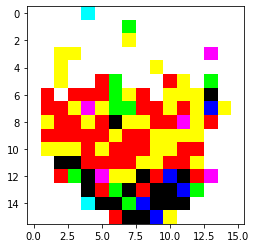

In [36]:
plt.imshow(w.reshape(16, 16, 3))

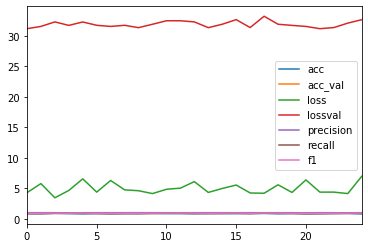

In [37]:
df.plot()

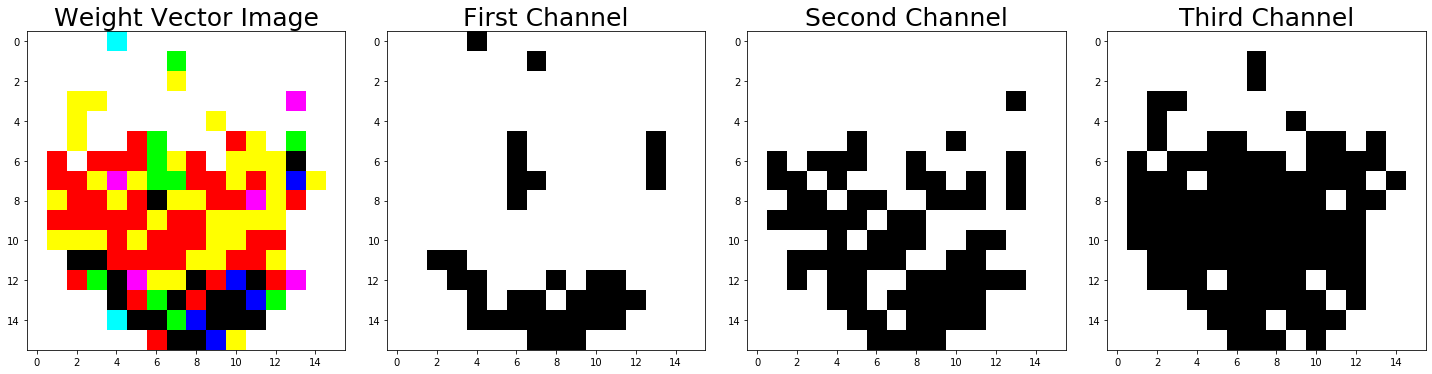

In [39]:
fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.imshow(w.reshape(16, 16, 3), cmap = plt.cm.gray, interpolation = 'nearest')
ax2.imshow(w.reshape(16, 16, 3)[..., 0], cmap = plt.cm.gray, interpolation = 'nearest')
ax3.imshow(w.reshape(16, 16, 3)[..., 1], cmap = plt.cm.gray, interpolation = 'nearest')
ax4.imshow(w.reshape(16, 16, 3)[..., 2], cmap = plt.cm.gray, interpolation = 'nearest')

ax1.set_title('Weight Vector Image', size=25)
ax2.set_title('First Channel', size=25)
ax3.set_title('Second Channel', size=25)
ax4.set_title('Third Channel', size=25)

plt.tight_layout()
plt.show()

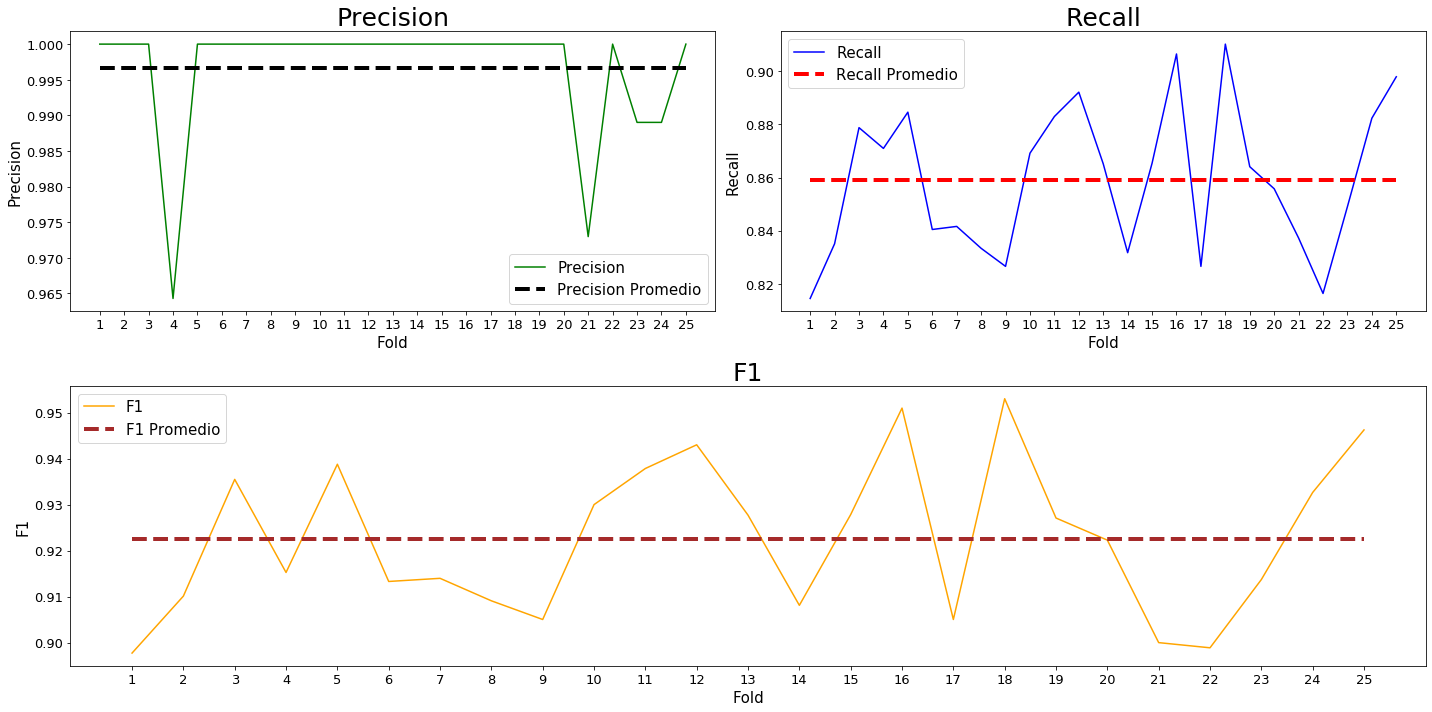

In [41]:
# Precision, Recall and F1 plot
precision = df['precision']
recall = df['recall']
f1 = df['f1']

epochs = range(1,26)

fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

ax1.plot(epochs, precision, 'g', label = 'Precision')
ax1.plot(epochs, [precision.values.mean()] * len(precision), c = 'black', label = 'Precision Promedio', ls = 'dashed', linewidth = 4)

ax2.plot(epochs, recall, 'b', label = 'Recall')
ax2.plot(epochs, [recall.values.mean()] * len(recall), c = 'red', label = 'Recall Promedio', ls = 'dashed', linewidth = 4)

ax3.plot(epochs, f1, 'orange', label = 'F1')
ax3.plot(epochs, [f1.values.mean()] * len(precision), c = 'brown', label = 'F1 Promedio', ls = 'dashed', linewidth = 4)

ax1.set_title('Precision', size=25)
ax1.set_xlabel('Fold', fontdict = {'fontsize' : 15})
ax1.set_ylabel('Precision', fontdict = {'fontsize' : 15})
ax1.legend(prop={'size': 15})
ax1.set_xticks(ticks = epochs)
ax1.tick_params(labelsize = 13)

ax2.set_title('Recall', size=25)
ax2.set_xlabel('Fold', fontdict = {'fontsize' : 15})
ax2.set_ylabel('Recall', fontdict = {'fontsize' : 15})
ax2.legend(prop={'size': 15})
ax2.set_xticks(ticks = epochs)
ax2.tick_params(labelsize = 13)

ax3.set_title('F1', size=25)
ax3.set_xlabel('Fold', fontdict = {'fontsize' : 15})
ax3.set_ylabel('F1', fontdict = {'fontsize' : 15})
ax3.legend(prop={'size': 15})
ax3.set_xticks(ticks = epochs)
ax3.tick_params(labelsize = 13)
plt.tight_layout()
plt.show()

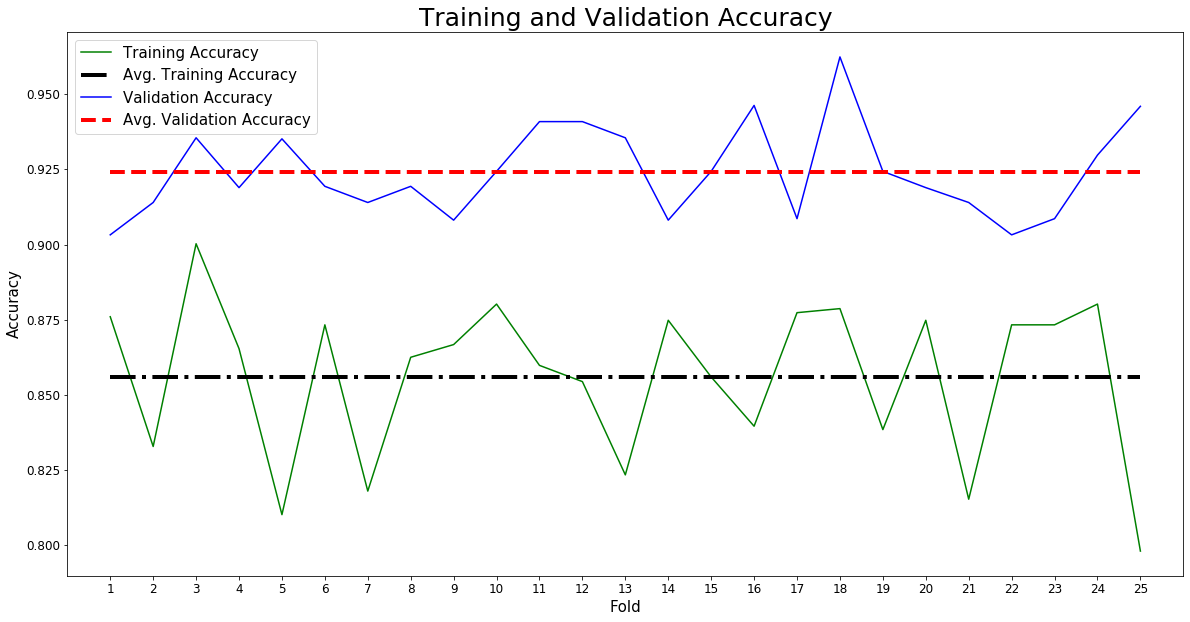

In [44]:
# Accuracy plot
acc = df['acc']
acc_val = df['acc_val']

epochs = range(1,26)

plt.figure(figsize = (20, 10))
plt.plot(epochs, acc, 'g', label = 'Training Accuracy')
plt.plot(epochs, [acc.values.mean()] * len(acc), 'black', label = 'Avg. Training Accuracy', ls = 'dashdot', linewidth = 4)
plt.plot(epochs, acc_val, 'b', label = 'Validation Accuracy')
plt.plot(epochs, [acc_val.values.mean()] * len(acc_val), 'red', label = 'Avg. Validation Accuracy', ls = 'dashed', linewidth = 4)
plt.title('Training and Validation Accuracy', fontdict = {'fontsize' : 25})
plt.xlabel('Fold', fontdict = {'fontsize' : 15})
plt.ylabel('Accuracy', fontdict = {'fontsize' : 15})
plt.legend()
plt.xlim((0, 26))
plt.xticks(ticks = epochs)
plt.tick_params(labelsize = 12)
plt.legend(prop={'size': 15})
plt.show()

## Predicting and evaluating a single trained classifier

In [47]:
Q = 8
test_threshold = 0.25
rs = 0
acc = 0
shots = 1024 * 8
N = 10 # -1 for full dataset
w, m, weights, ae = fit(qubits = Q, X_train = X_train[:N], Y_train = Y_train[:N], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = test_threshold, Ip = .8, In = .1, bias = 0.0, w = w)

Coincide in 10 and change 1 bits
Coincide1 in 60 and change 6 bits
Coincide2 in 80 and change 8 bits
Coincide1 in 70 and change 56 bits
Coincide2 in 66 and change 52 bits

Errors = 2 for accuracy of = 0.8



In [48]:
classification, readouts = predict(qubits = Q, X_test = X_test[:N], negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)

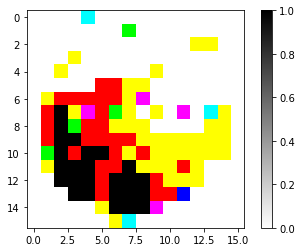

In [49]:
c = plt.imshow(np.array(w).reshape(16, 16, 3)[..., :], cmap = 'gray_r')
plt.colorbar(c)

In [50]:
accuracy, counts, confusion_matriX = evaluate(Y_test, classification, number_negative_class, number_positive_class)
print(f'Accuracy = {accuracy}')
print(f'Counts = {counts}')
print(f'Confusion Matrix = \n{confusion_matriX}')

Accuracy = 0.0
Counts = Counter()
Confusion Matrix = 
[[3. 1.]
 [0. 6.]]


C:\Users\jeff_\Anaconda3\lib\site-packages\ipykernel_launcher.py:326: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


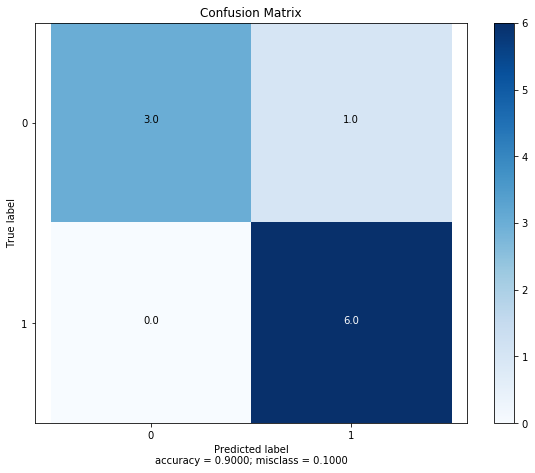

In [56]:
plot_confusion_matrix(confusion_matriX, target_names = np.array([number_negative_class, number_positive_class]), labels = True, normalize = False)

In [59]:
accuracy_score(Y_test[:N], classification)

0.9

In [61]:
precision_score(Y_test[:N], classification, average = 'binary', pos_label = number_negative_class)

1.0

In [62]:
recall_score(Y_test[:N], classification, average = 'binary', pos_label = number_negative_class)

0.75

In [63]:
f1_score(Y_test[:N], classification, average = 'binary', pos_label = number_negative_class)

0.8571428571428571

AUC: 0.875


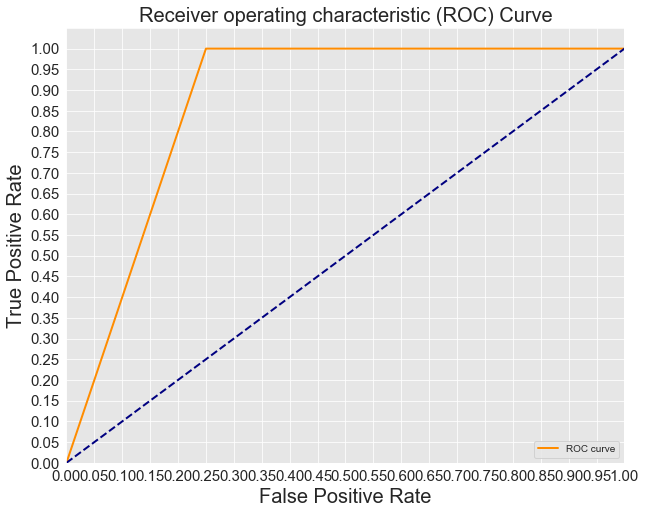

In [65]:
test = [0 if ele == number_negative_class else 1 for ele in Y_test[:N]]
classi = [0 if ele == number_negative_class else 1 for ele in classification]

fpr, tpr, thresholds = roc_curve(test, classi)

def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)], fontsize = 15)
    plt.xticks([i/20.0 for i in range(21)], fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('Receiver operating characteristic (ROC) Curve', fontsize = 20)
    plt.legend(loc='lower right')
    plt.show()

ROC_curve(fpr,tpr)
sns.set_style('white', {'axes.facecolor': '0.9'})


## Manual process analysis

In [124]:
classification.astype(int)

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [125]:
Y_test

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [126]:
fails = np.where(classification != Y_test)[0]
print(fails)

[  3  18  30  92  96 111 123 125 179 181]


In [127]:
X_test = np.array(X_test)
for x in X_test[fails]:
    print(np.power((np.where(weights[0] == x)[0].shape[0] - np.where(weights[0] != x)[0].shape[0]) / x.shape[0], 2))

21904.0
25387.111111111113
23921.777777777774
23511.111111111113
21904.0
21511.11111111111
20164.0
23921.777777777774
23307.11111111111
22700.44444444444


In [128]:
print(np.sort(readouts[np.where(Y_test == number_negative_class)]), end = '\n\n')
print(np.sort(readouts[np.where(Y_test == number_positive_class)]))
print(np.sort(readouts[fails]))

[0.50976562 0.52111816 0.52661133 0.55407715 0.57373047 0.57617188
 0.57971191 0.59802246 0.61425781 0.625      0.62854004 0.62890625
 0.63183594 0.63745117 0.65478516 0.65649414 0.66369629 0.68432617
 0.68554688 0.68615723 0.69042969 0.70092773 0.70202637 0.70483398
 0.71203613 0.71264648 0.72167969 0.7232666  0.72363281 0.72473145
 0.7277832  0.73413086 0.73425293 0.74389648 0.74487305 0.74731445
 0.74938965 0.75146484 0.75158691 0.75183105 0.75231934 0.75439453
 0.75585938 0.7578125  0.75866699 0.75927734 0.76025391 0.7611084
 0.76147461 0.76489258 0.76794434 0.77062988 0.77233887 0.77392578
 0.77563477 0.77990723 0.78198242 0.78259277 0.78503418 0.78540039
 0.78625488 0.7869873  0.78723145 0.78808594 0.78845215 0.79016113
 0.79040527 0.79089355 0.79101562 0.79101562 0.7911377  0.79162598
 0.79248047 0.79248047 0.79272461 0.79296875 0.79309082 0.79309082
 0.79345703 0.79370117 0.79394531 0.79431152 0.79443359 0.79455566
 0.79467773 0.79492188 0.7956543  0.79577637 0.79589844 0.79638

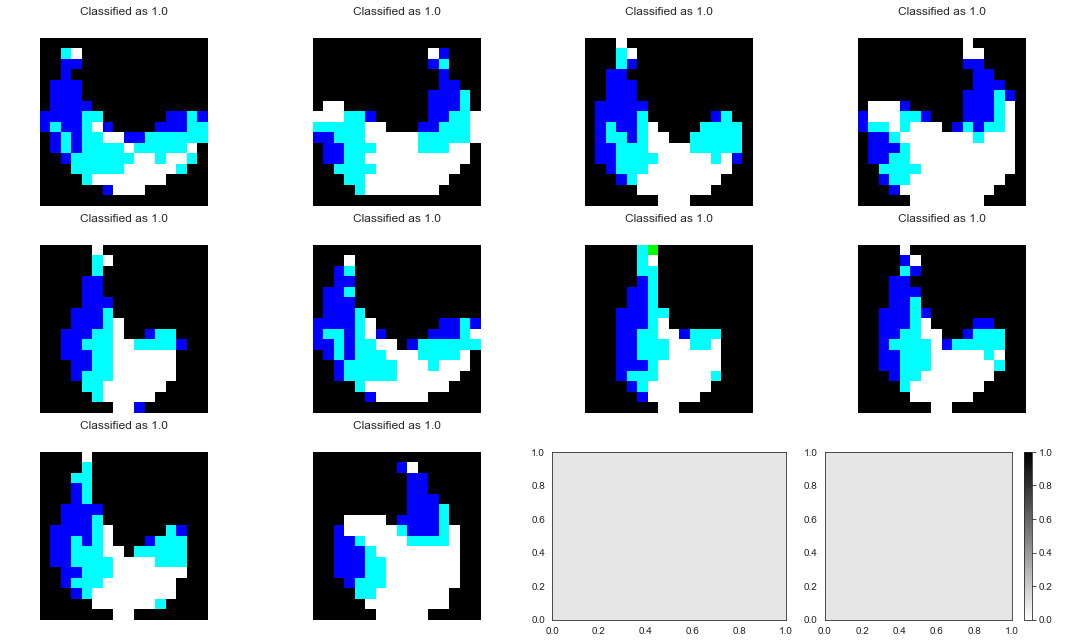

In [130]:
fig, axs = plt.subplots(3, int(np.ceil(len(fails) / 3)), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(fails) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(X_test[fails[count]]).reshape(16, 16, 3), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Classified as {classification[fails[count]]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
plt.colorbar(c)
plt.show()

In [131]:
Counter(Y_test)

Counter({1: 89, 0: 97})

In [132]:
readouts

array([0.60046387, 0.43078613, 0.56347656, 0.63183594, 0.79431152,
       0.78723145, 0.58581543, 0.55859375, 0.52111816, 0.41357422,
       0.38269043, 0.30944824, 0.77233887, 0.39892578, 0.78808594,
       0.5032959 , 0.74731445, 0.79345703, 0.71203613, 0.79089355,
       0.5949707 , 0.4395752 , 0.53771973, 0.43005371, 0.68432617,
       0.7956543 , 0.50341797, 0.74389648, 0.79638672, 0.71264648,
       0.57373047, 0.79577637, 0.33349609, 0.79443359, 0.45812988,
       0.61083984, 0.70483398, 0.78198242, 0.54309082, 0.79455566,
       0.4699707 , 0.56164551, 0.50769043, 0.70092773, 0.28771973,
       0.79309082, 0.79589844, 0.55407715, 0.52575684, 0.78259277,
       0.77563477, 0.47058105, 0.7578125 , 0.796875  , 0.54650879,
       0.75866699, 0.6072998 , 0.52783203, 0.56677246, 0.46862793,
       0.25964355, 0.45788574, 0.57067871, 0.56896973, 0.53747559,
       0.79394531, 0.33886719, 0.50378418, 0.22729492, 0.46643066,
       0.65478516, 0.60083008, 0.46032715, 0.54846191, 0.77392

In [133]:
indexes = [i for i in range(len(readouts))]

In [134]:
list(zip(indexes, Y_test, readouts))

[(0, 1, 0.6004638671875),
 (1, 1, 0.4307861328125),
 (2, 1, 0.5634765625),
 (3, 0, 0.6318359375),
 (4, 0, 0.7943115234375),
 (5, 0, 0.7872314453125),
 (6, 1, 0.5858154296875),
 (7, 1, 0.55859375),
 (8, 0, 0.5211181640625),
 (9, 1, 0.41357421875),
 (10, 1, 0.3826904296875),
 (11, 1, 0.3094482421875),
 (12, 0, 0.7723388671875),
 (13, 1, 0.39892578125),
 (14, 0, 0.7880859375),
 (15, 1, 0.5032958984375),
 (16, 0, 0.747314453125),
 (17, 0, 0.79345703125),
 (18, 0, 0.7120361328125),
 (19, 0, 0.7908935546875),
 (20, 1, 0.594970703125),
 (21, 1, 0.4395751953125),
 (22, 1, 0.5377197265625),
 (23, 1, 0.4300537109375),
 (24, 0, 0.684326171875),
 (25, 0, 0.795654296875),
 (26, 1, 0.50341796875),
 (27, 0, 0.743896484375),
 (28, 0, 0.79638671875),
 (29, 0, 0.712646484375),
 (30, 0, 0.57373046875),
 (31, 0, 0.7957763671875),
 (32, 1, 0.33349609375),
 (33, 0, 0.79443359375),
 (34, 1, 0.4581298828125),
 (35, 1, 0.61083984375),
 (36, 0, 0.704833984375),
 (37, 0, 0.781982421875),
 (38, 1, 0.5430908203125

Text(0, 0.5, 'Training Readout')

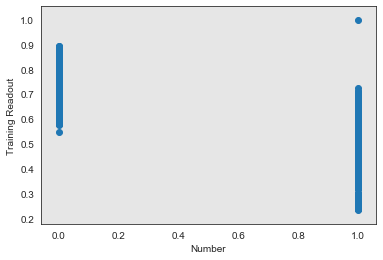

In [135]:
#%matplotlib qt
plt.scatter(Y_train, m[-1])
plt.xlabel("Number")
plt.ylabel("Training Readout")
#%matplotlib inline

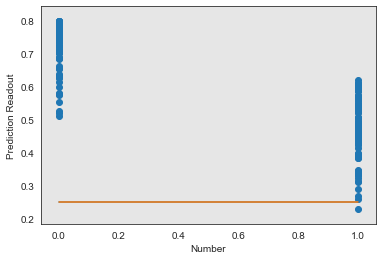

In [136]:
#%matplotlib qt
plt.scatter(Y_test, readouts)
plt.xlabel("Number")
plt.ylabel("Prediction Readout")
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])
plt.plot([i for i in range(min(number_negative_class, number_positive_class), max(number_negative_class, number_positive_class) + 1)], [test_threshold for _ in range(abs(number_negative_class - number_positive_class) + 1)])
#%matplotlib inline

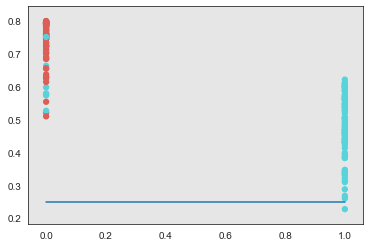

In [137]:
classification_auxiliar = classification / np.max(classification)
palette = np.array(sns.color_palette("hls", 2))  #Choosing color palette 
plt.scatter(Y_test, readouts, lw=0, s=40, c=palette[classification_auxiliar.astype(np.int)])
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])

In [138]:
Y_test

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

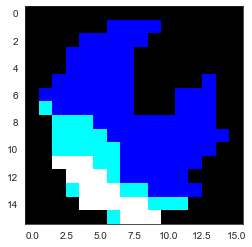

In [139]:
plt.imshow(np.array(X_test[2]).reshape(16, 16, 3), cmap=plt.cm.gray, interpolation='nearest')

In [140]:
np.array(X_test[2]).reshape(16, 16, 3)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
      

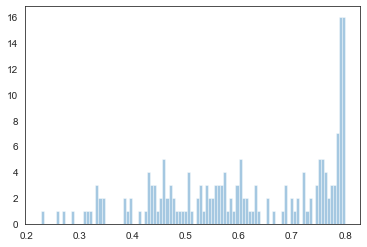

In [141]:
import seaborn as sns
sns.set_style('white')
sns.distplot(readouts, bins = 100, kde = False)

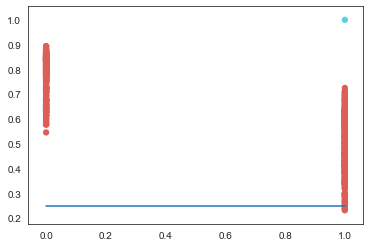

In [142]:
palette = np.array(sns.color_palette("hls", 2))  #Choosing color palette 
plt.scatter(Y_train, m[-1], lw=0, s=40, c=palette[m[-1].astype(np.int)])
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])

In [663]:
filename = 'weights_OvA.txt'
mode = 'a+'
save_weight(filename = filename, mode = mode, weight = w)